##  Chargement  des données 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("2016_building_energy_benchmarking.csv")


Verfions que cela a été fait

In [3]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

### Location des batiment à étudier dans la ville de  Seattle


In [5]:
import folium
map_osm = folium.Map()
map_osm = folium.Map(location=[data['Latitude'].mean(), data['Longitude'].mean()],zoom_start=11)
for i in range(0,len(data)):
    folium.Circle([data.iloc[i]['Latitude'],data.iloc[i]['Longitude']], 
                      popup=data.iloc[i]['Address'], radius =100).add_to(map_osm)
map_osm

## Explore le dataset pour identifier les deafauts

### 1. Taux de valeurs manquantes en %

In [6]:
missing_rate = (data.isna().sum()/data.shape[0])*100


**Graphique du taux de valeurs manquantes**

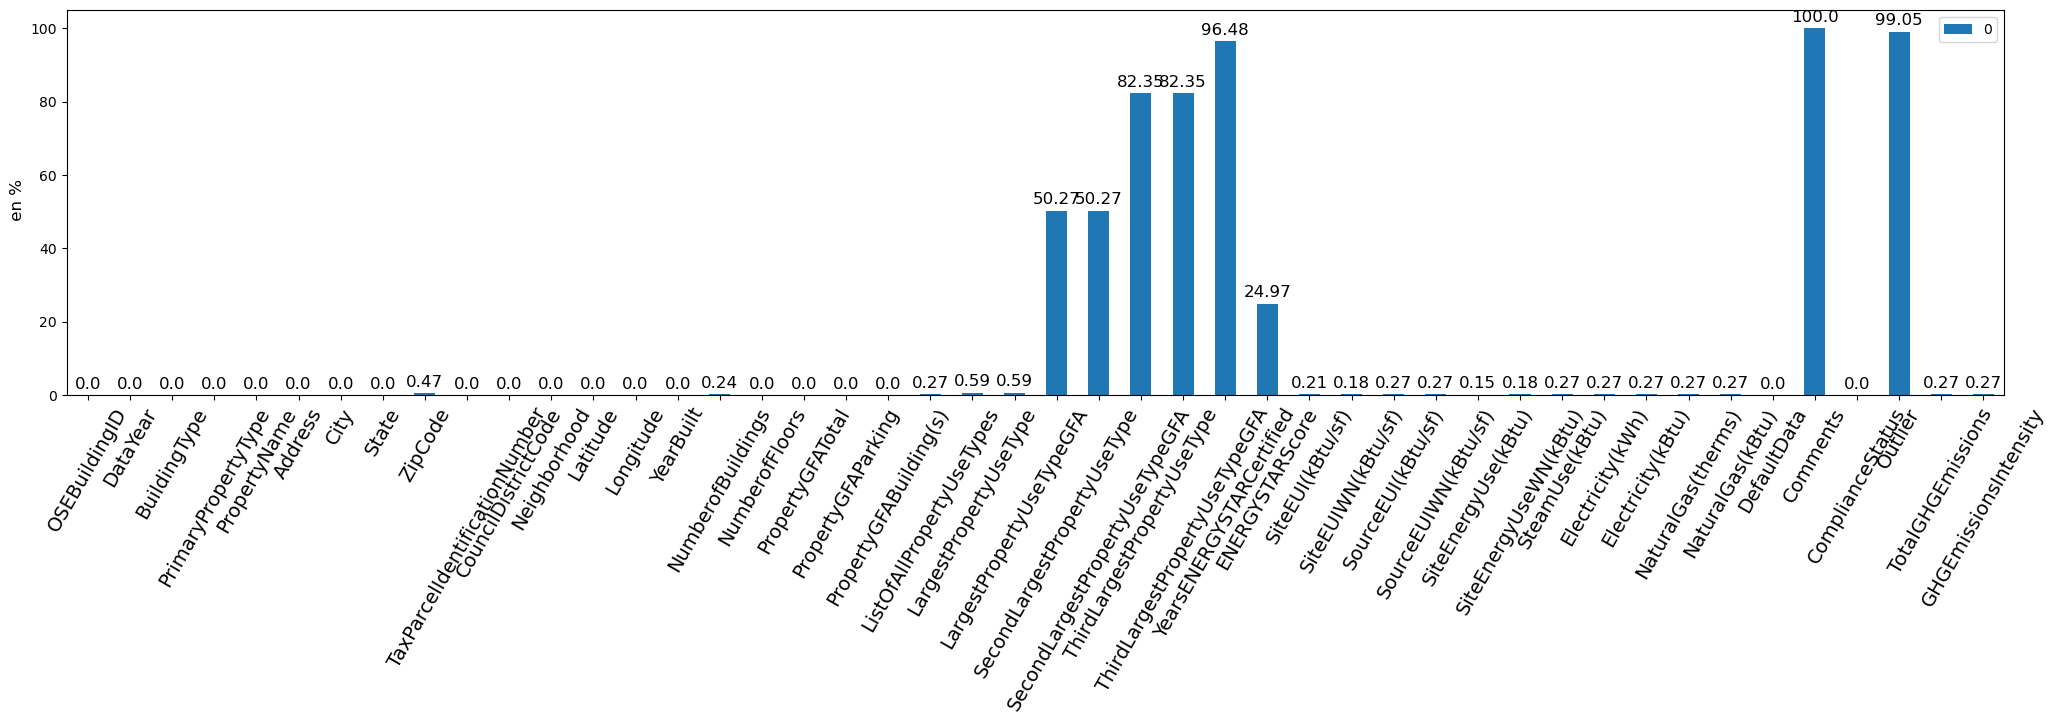

In [9]:
missing_rate = pd.DataFrame(missing_rate)
ax = missing_rate.plot.bar(figsize=(25,5))

ax.set_ylabel(" en %", fontsize=12)

# Ajouter les annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 12,
                )
    plt.xticks(rotation='60', fontsize=14)

### 2. Verfions s'il ya les valeurs aberrantes

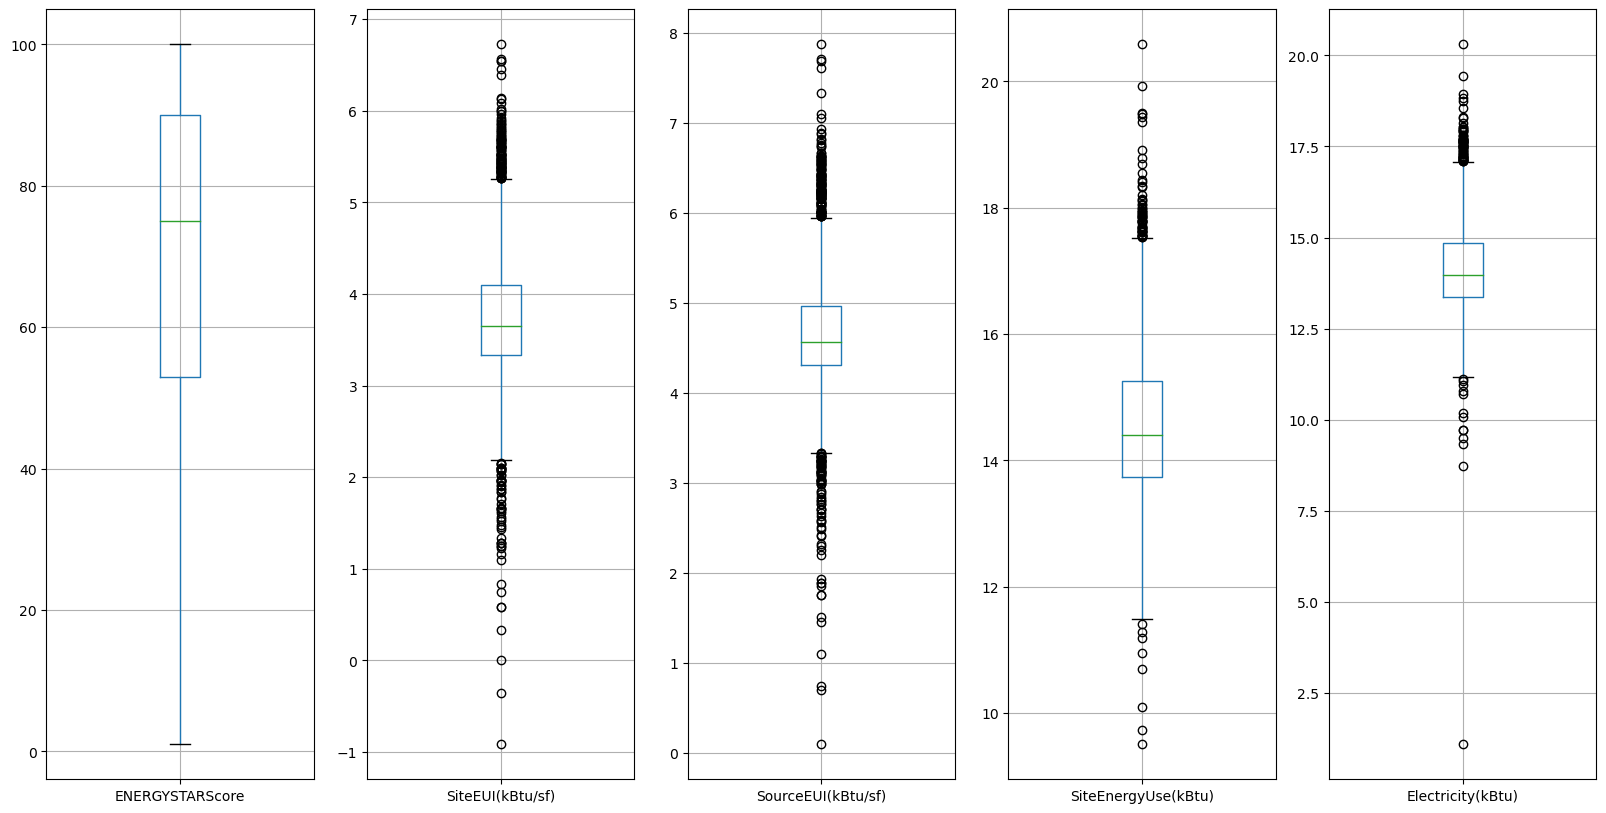

In [7]:
plt.figure(1, figsize=(20,10))

plt.subplot(151)
data[['ENERGYSTARScore']].boxplot()


plt.subplot(152)
np.log(data[['SiteEUI(kBtu/sf)']]).boxplot()

plt.subplot(153)
np.log(data[['SourceEUI(kBtu/sf)']]).boxplot()

plt.subplot(154)
np.log(data[['SiteEnergyUse(kBtu)']]).boxplot()

plt.subplot(155)
np.log(data[['Electricity(kBtu)']]).boxplot()
plt.show()

Nous voyons qu'il y a des valeurs aberrantes dans notre ensemble de données

Notons que l'intensité d'utilisation de l'énergie du site (IUE) est la consommation d'énergie du site d'une propriété divisée par sa surface de plancher brute. La consommation énergétique du site est la quantité annuelle de toute l'énergie consommée par la propriété sur le site. Le site EUI est mesuré en milliers d'unités thermiques britanniques (kBtu) par pied carré.

***Voir la distribution d'energie par histogramme***

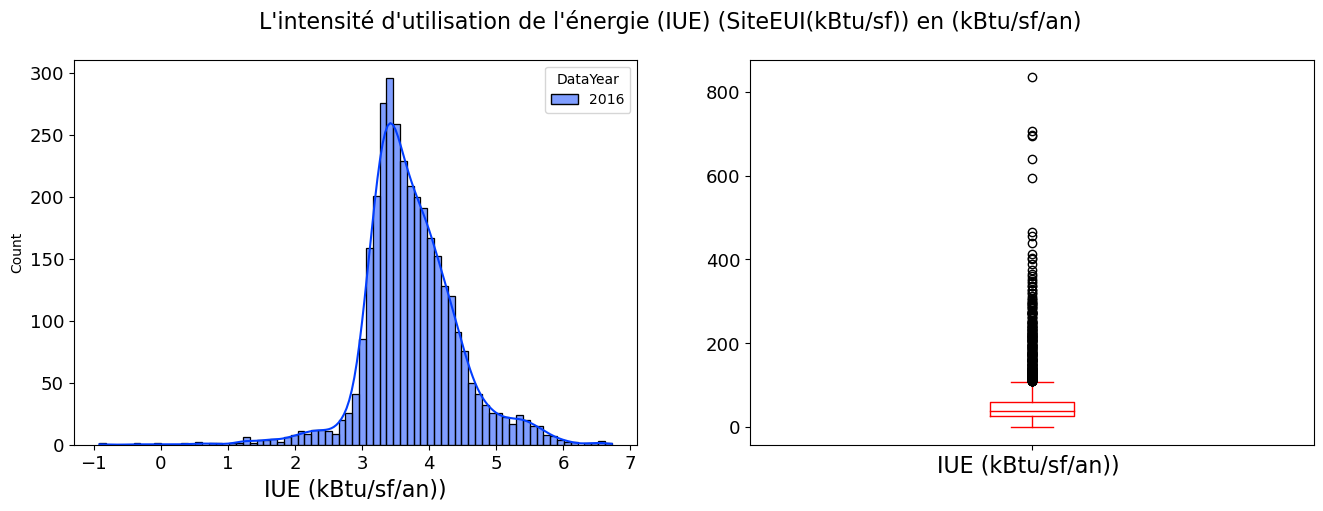

In [8]:
plt.figure(1, figsize=(30,30))

plt.subplot(121)
#fig = sns.histplot(data=data, x=data['SiteEUI(kBtu/sf)'], kde=True, hue='DataYear', palette='bright')
fig = sns.histplot(data=data, x=np.log(data['SiteEUI(kBtu/sf)']), kde=True, hue='DataYear', palette='bright')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.set_xlabel("IUE (kBtu/sf/an))", fontsize=16)

plt.subplot(122)
ax = data['SiteEUI(kBtu/sf)'].plot.box(figsize=(16,5), color='red')
ax.set_xticklabels(["IUE (kBtu/sf/an)) "])


plt.suptitle("L'intensité d'utilisation de l'énergie (IUE) (SiteEUI(kBtu/sf)) en (kBtu/sf/an) ",fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=13)

plt.show()

L'intensité de la consommation d'énergie à la source (IUE) est la consommation d'énergie à la source d'une propriété divisée par sa surface de plancher brute

La consommation d'énergie à la source est l'énergie annuelle utilisée pour exploiter la propriété, y compris les pertes de production, de transmission et de distribution. La source EUI est mesurée en milliers d'unités thermiques britanniques (kBtu) par pied carré.

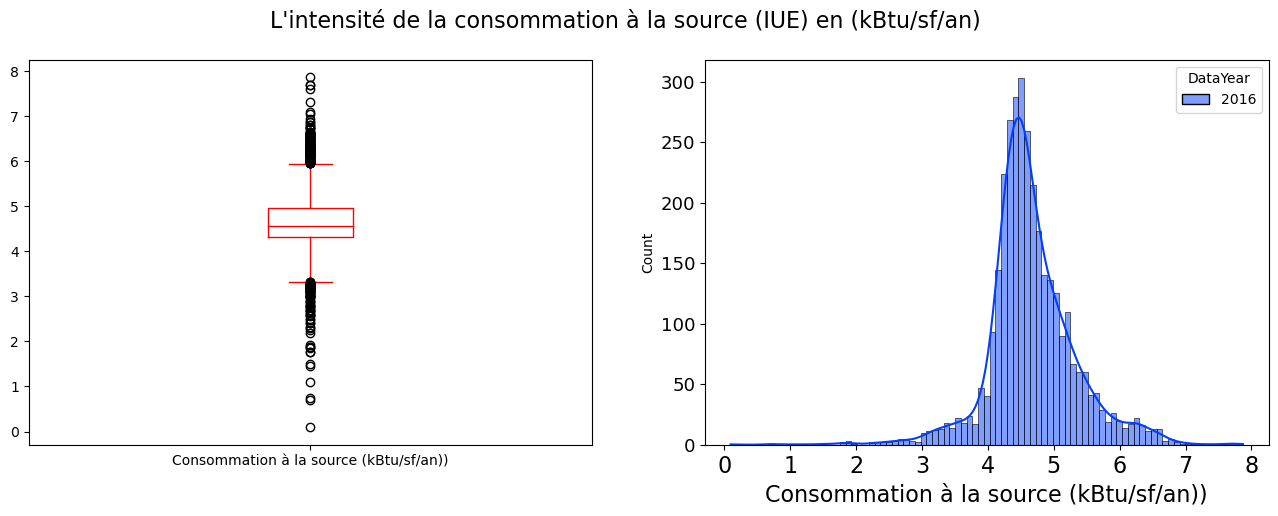

In [9]:
plt.figure(1, figsize=(30,30))

plt.subplot(121)

ax = np.log(data['SourceEUI(kBtu/sf)']).plot.box(figsize=(16,5), color='red')
ax.set_xticklabels(["Consommation à la source (kBtu/sf/an))"])


plt.subplot(122)
fig = sns.histplot(data=data, x=np.log(data['SourceEUI(kBtu/sf)']), kde=True, hue='DataYear', palette='bright')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.set_xlabel("Consommation à la source (kBtu/sf/an))", fontsize=16)



plt.suptitle("L'intensité de la consommation à la source (IUE) en (kBtu/sf/an) ",fontsize=16)

plt.xticks(fontsize=16)
plt.yticks(fontsize=13)


plt.show()

***Traçons l'histogramme de SiteEnergyUse(kBtu)***

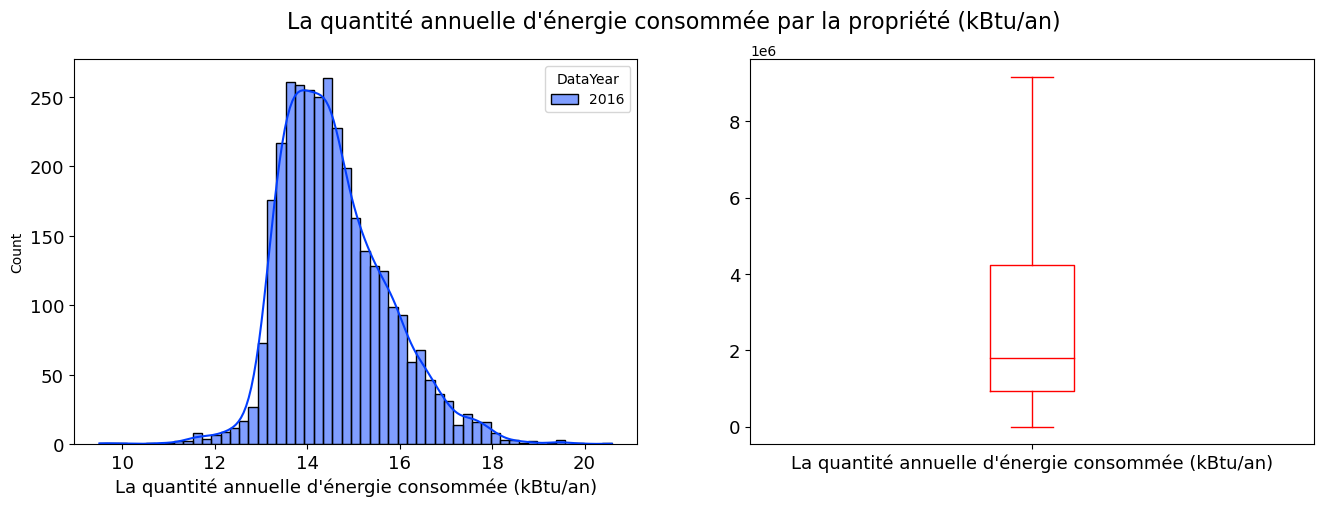

In [10]:
plt.figure(1, figsize=(30,15))

plt.subplot(121)
fig = sns.histplot(data=data, x=np.log(data['SiteEnergyUse(kBtu)']),
                   kde=True, hue='DataYear', palette='bright')

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.set_xlabel("La quantité annuelle d'énergie consommée (kBtu/an)", fontsize=13)

plt.subplot(122)
ax = data['SiteEnergyUse(kBtu)'].plot.box(figsize=(16,5), color='red',showfliers=False)
ax.set_xticklabels(["La quantité annuelle d'énergie consommée (kBtu/an)"])


plt.suptitle("La quantité annuelle d'énergie consommée par la propriété (kBtu/an)",fontsize=16)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

La quantité annuelle d'électricité consommée par la propriété sur place, y compris l'électricité achetée à partir du réseau et générée par des systèmes renouvelables sur place, mesurée en milliers d'unités thermiques britanniques (kBtu).



***Lessons nous voir l'histogramme de 'Electricity(kBtu)***

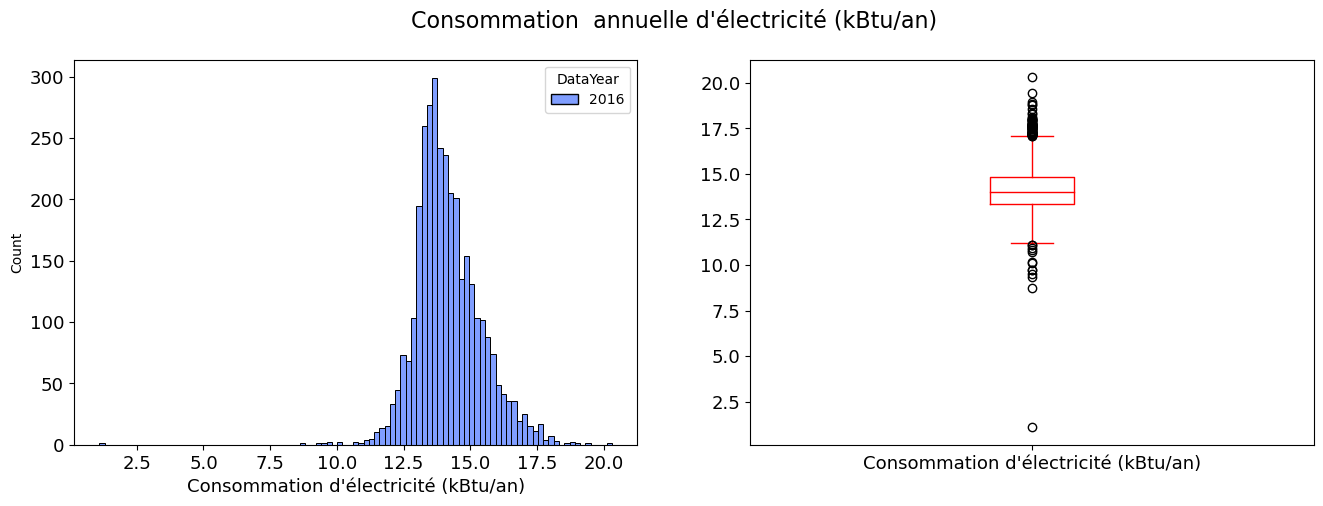

In [11]:
plt.figure(1, figsize=(30,15))

plt.subplot(121)
fig = sns.histplot(data=data, x=np.log(data['Electricity(kBtu)']), hue='DataYear', palette='bright')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
fig.set_xlabel("Consommation d'électricité (kBtu/an)", fontsize=13)

plt.subplot(122)
ax = np.log(data['Electricity(kBtu)']).plot.box(figsize=(16,5), color='red')
ax.set_xticklabels(["Consommation d'électricité (kBtu/an)"])


plt.suptitle("Consommation  annuelle d'électricité (kBtu/an)",fontsize=16)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

***Calculons La quantité annuelle d'énergie consommée (SiteEnergyUseWN(kBtu)) par pied carré pour chaque bâtiment***

In [12]:
data['Energy_use_par_area'] = data['SiteEnergyUse(kBtu)']/data['PropertyGFATotal']

data[['PropertyGFATotal', 'SiteEnergyUse(kBtu)' , 'Energy_use_par_area']]

PropertyGFATotal  SiteEnergyUse(kBtu)  Energy_use_par_area
0                88434         7.226362e+06            81.714753
1               103566         8.387933e+06            80.991184
2               956110         7.258702e+07            75.919114
3                61320         6.794584e+06           110.805349
4               175580         1.417261e+07            80.718795
...                ...                  ...                  ...
3371             12294         8.497457e+05            69.118732
3372             16000         9.502762e+05            59.392262
3373             13157         5.765898e+06           438.238048
3374             14101         7.194712e+05            51.022707
3375             18258         1.152896e+06            63.144717

[3376 rows x 3 columns]

Text(0.5, 0, 'Type de propriété')

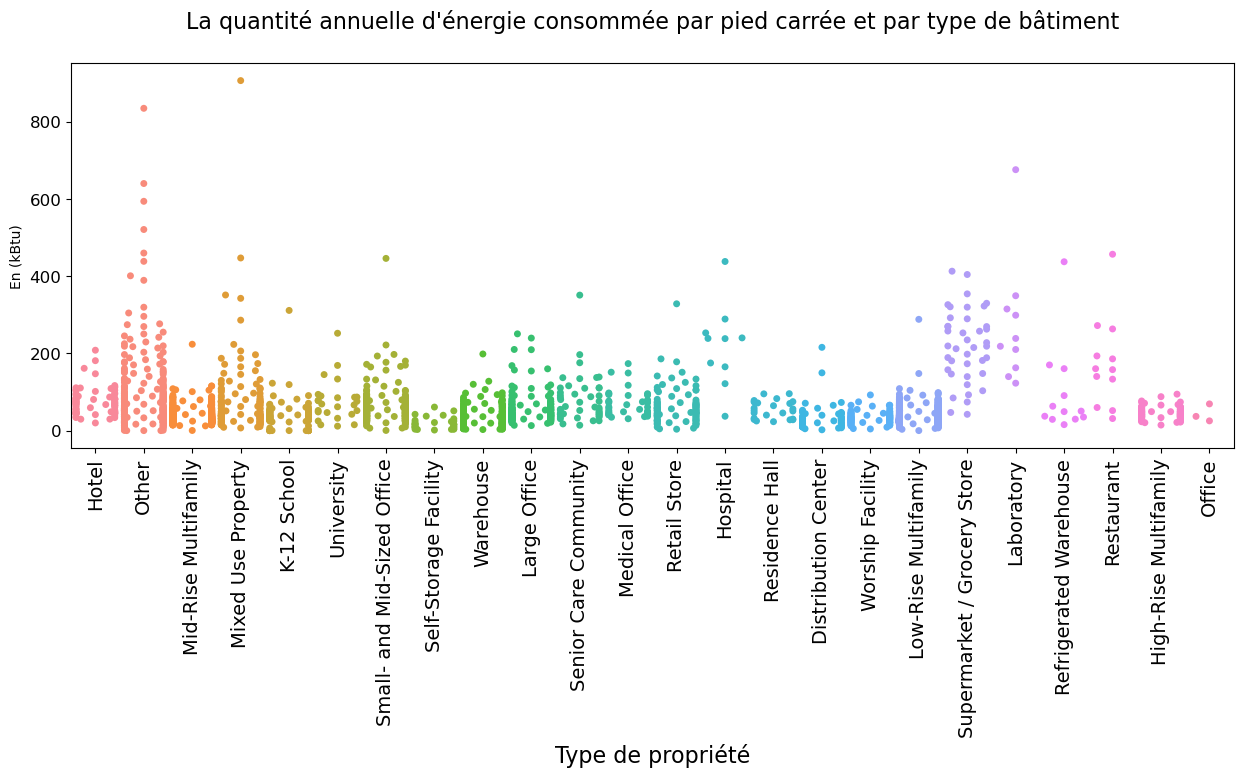

In [13]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


grouped =data.loc[:,['PrimaryPropertyType', 'Energy_use_par_area']] \
    .groupby(['PrimaryPropertyType']) \
    .median() \
    .sort_values(by='Energy_use_par_area')




sns.swarmplot(x= data['PrimaryPropertyType'], y = data['Energy_use_par_area'], data = data)


fig.set_size_inches(15, 5)
ax.set_ylabel("En (kBtu)", fontsize=10)
ax.set_title("La quantité annuelle d'énergie consommée par pied carrée et par type de bâtiment\n", fontsize=16)
plt.xticks(rotation='90', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Type de propriété', fontsize=16)

Text(0.5, 0, 'Type de propriété')

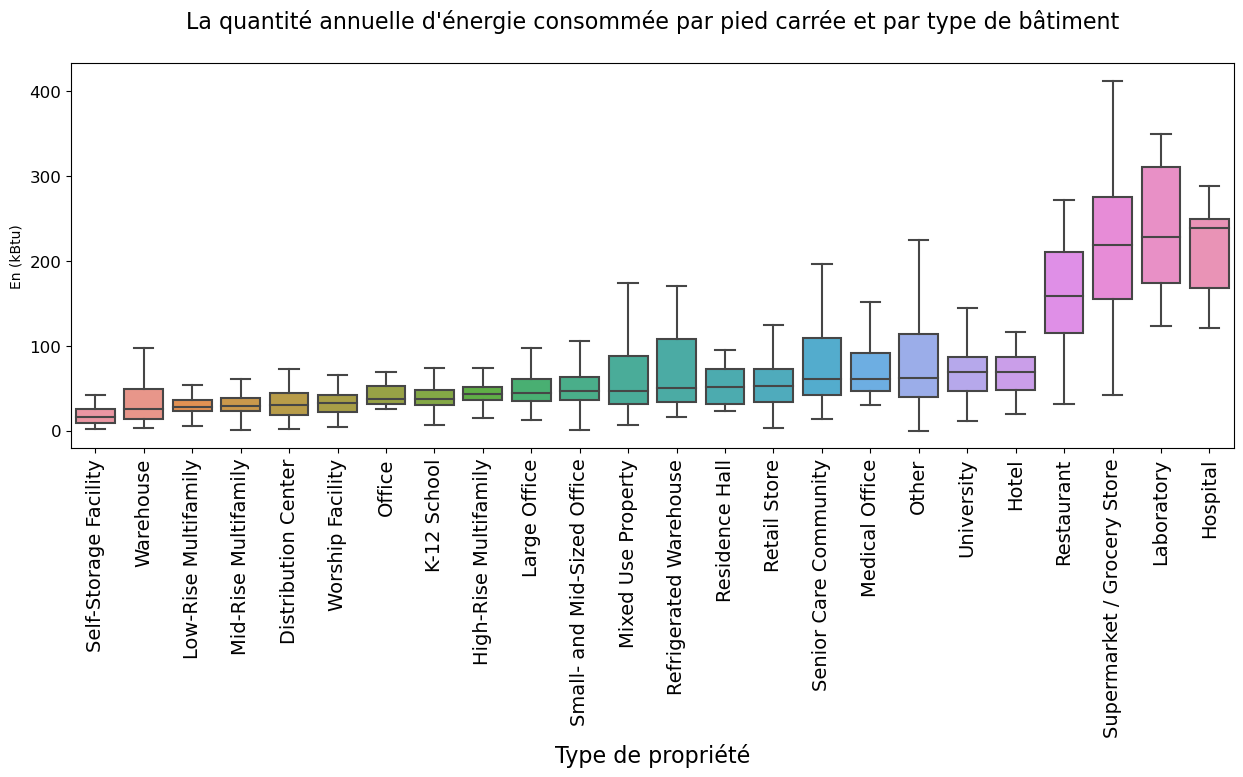

In [14]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


grouped =data.loc[:,['PrimaryPropertyType', 'Energy_use_par_area']] \
    .groupby(['PrimaryPropertyType']) \
    .median() \
    .sort_values(by='Energy_use_par_area')



sns.boxplot(x= data['PrimaryPropertyType'], y = data['Energy_use_par_area'], data = data, order=grouped.index,showfliers=False)

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(15, 5)
ax.set_ylabel("En (kBtu)", fontsize=10)
ax.set_title("La quantité annuelle d'énergie consommée par pied carrée et par type de bâtiment\n", fontsize=16)
plt.xticks(rotation='90', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('Type de propriété', fontsize=16)


**Calculer la proportions des sources d’énergies utilisées (en %) par pied carré pour chaque bâtiment**

In [15]:
data['Energy_Source_proportion'] = (data['SiteEUI(kBtu/sf)']/data['SourceEUI(kBtu/sf)'])*100

data[['SiteEUI(kBtu/sf)', 'SourceEUI(kBtu/sf)' , 'Energy_Source_proportion']]

SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  Energy_Source_proportion
0            81.699997          182.500000                 44.767122
1            94.800003          176.100006                 53.833049
2            96.000000          241.899994                 39.685822
3           110.800003          216.199997                 51.248846
4           114.800003          211.399994                 54.304639
...                ...                 ...                       ...
3371         69.099998          161.699997                 42.733457
3372         59.400002          114.199997                 52.014013
3373        438.200012          744.799988                 58.834589
3374         51.000000          105.300003                 48.433047
3375         63.099998          115.800003                 54.490498

[3376 rows x 3 columns]

Text(0.5, 0, '\nType de propriété')

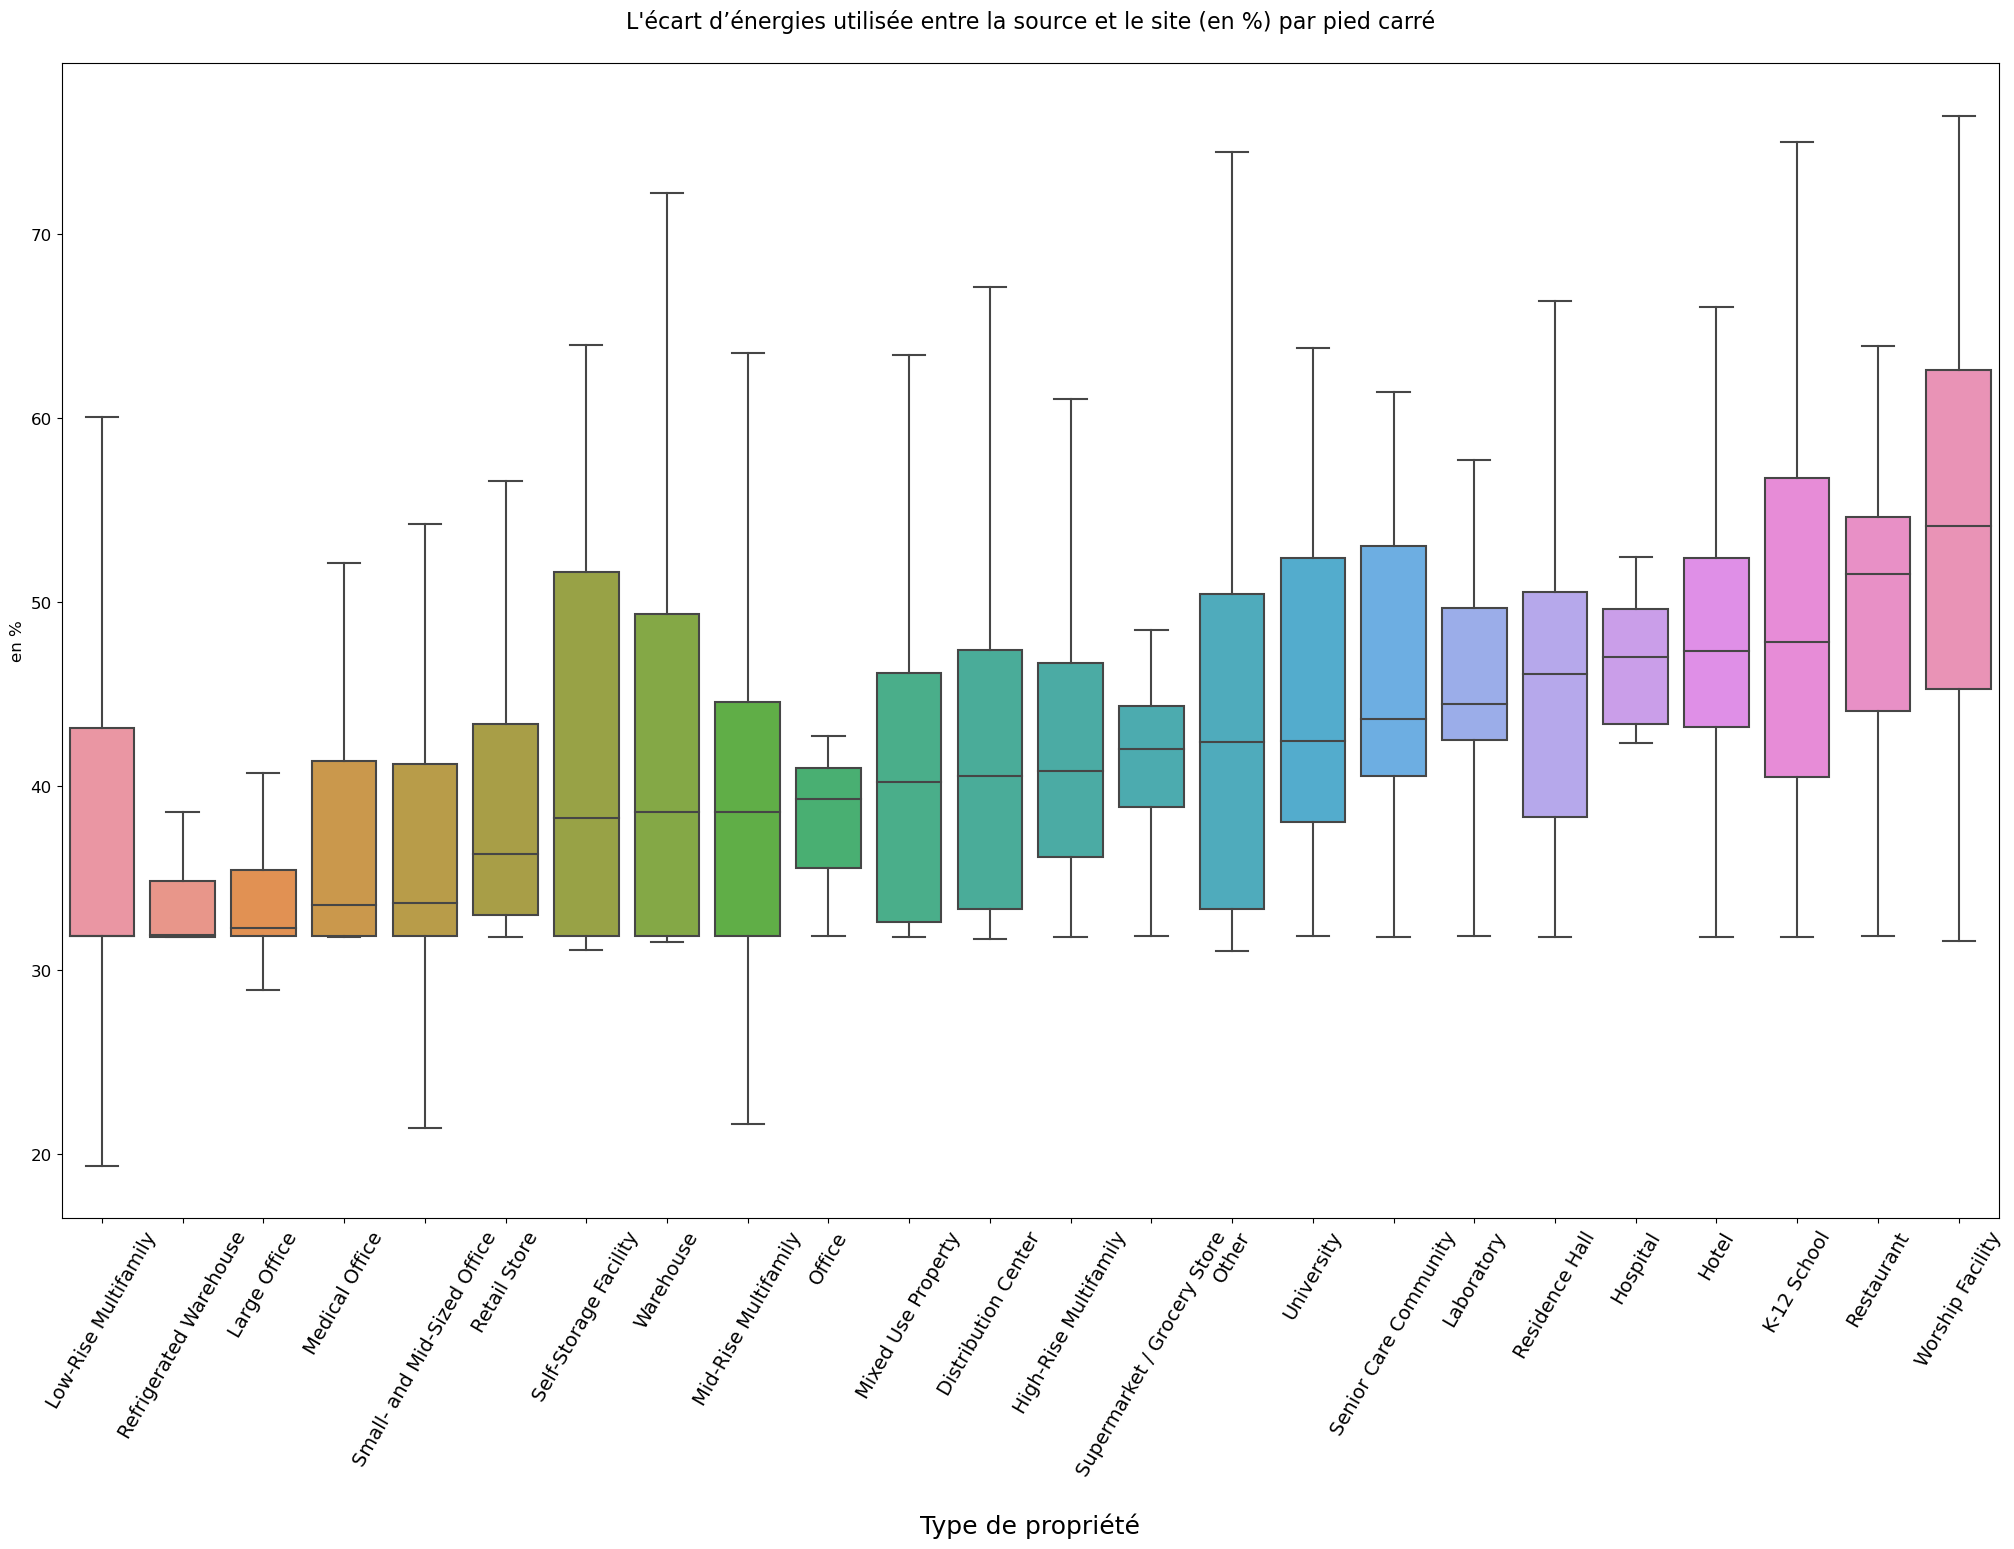

In [16]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


grouped = data.loc[:,['PrimaryPropertyType', 'Energy_Source_proportion']].groupby(['PrimaryPropertyType']) \
    .median() \
    .sort_values(by='Energy_Source_proportion')



sns.boxplot(x= data['PrimaryPropertyType'], y = data['Energy_Source_proportion'], data = data, 
            order=grouped.index,showfliers=False)

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(25, 15)
ax.set_ylabel("en %", fontsize=12)
ax.set_title("L'écart d’énergies utilisée entre la source et le site (en %) par pied carré\n", fontsize=16)

plt.xticks(fontsize=14)
plt.xticks(rotation='60', fontsize=14)
plt.yticks(fontsize=12)
plt.xlabel('\nType de propriété', fontsize=18)

***représentons les bâtiments par catégorie***

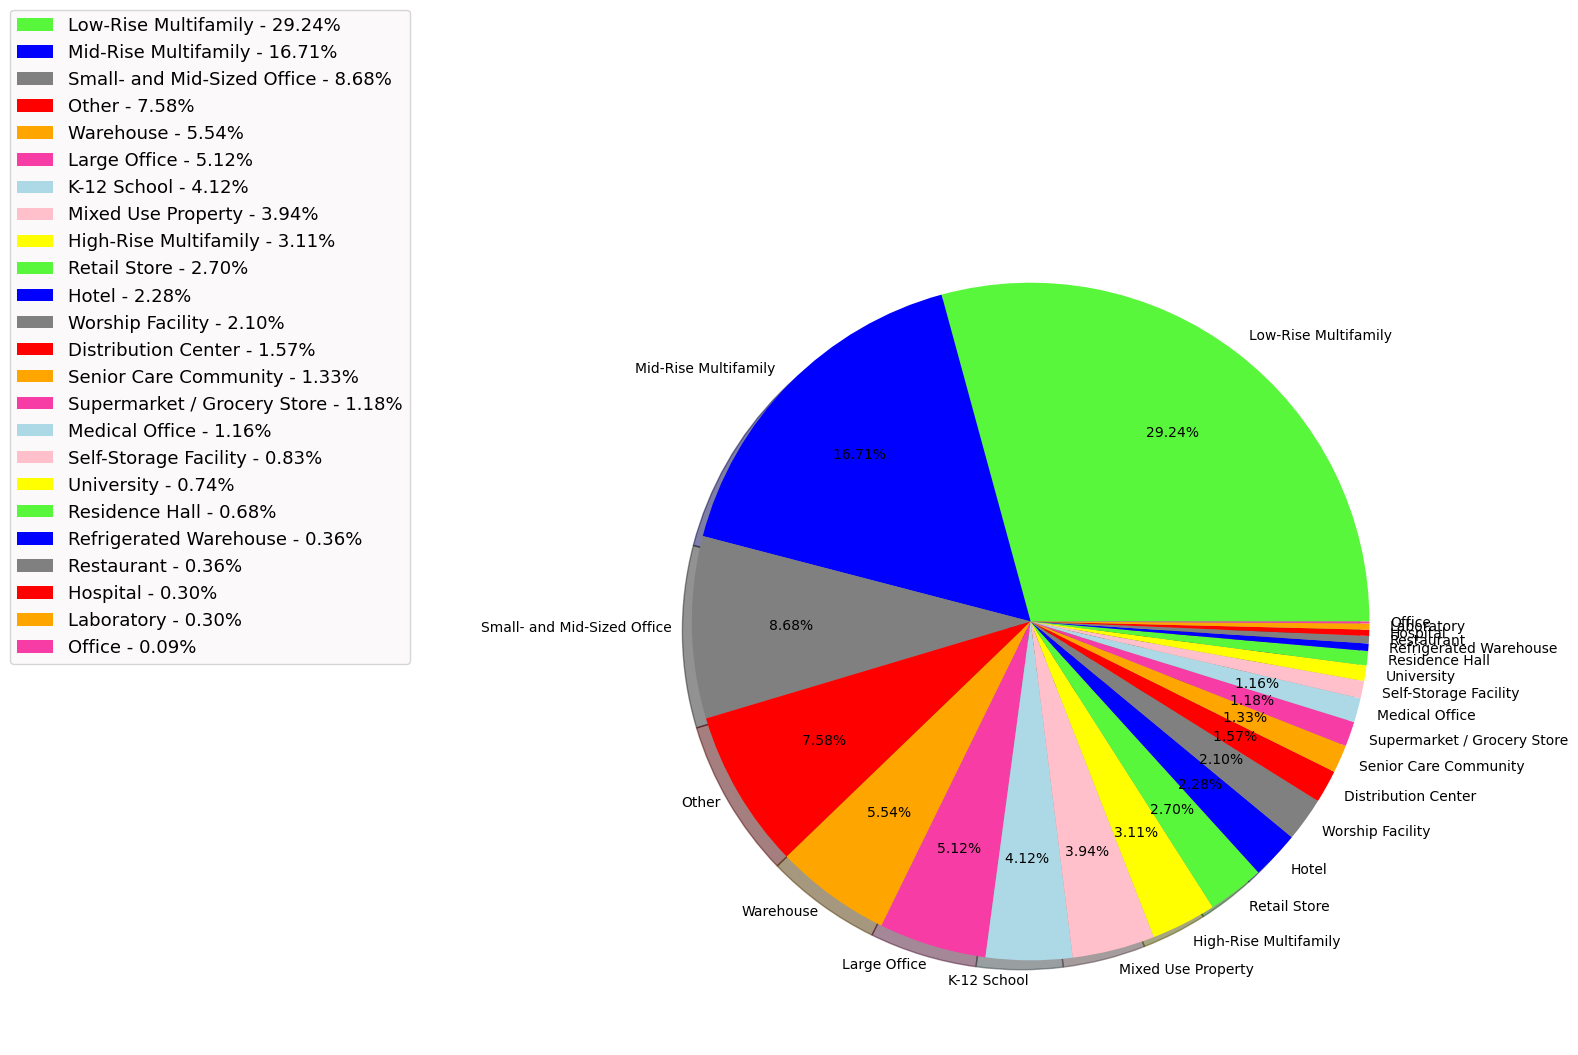

In [17]:
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if (val/total)>0.01 : 
          # return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
          return '{p:.2f}% '.format(p=pct)
    return my_autopct

plt.figure(figsize = (11, 11))


colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']

sns.set_palette(sns.color_palette(colors))

y = data['PrimaryPropertyType'].value_counts().index
x = data['PrimaryPropertyType'].value_counts().values
labels =y

plt.pie(x, labels=y,
           autopct = make_autopct(x),
           pctdistance = 0.7, 
           labeldistance = 1.06,
           shadow = True)


plt.legend(y, loc=[-.705,0.45], labels=['%s - %1.2f%%' % (l, s) for l, 
                                       s in zip(labels, (x/sum(x))*100)],
           fontsize=13,facecolor='#fbf8f8')


***Calculons la moyenne par Type de propriété (PrimaryPropertyType)***

In [18]:
categorie = data['PrimaryPropertyType'].unique()

df_categorie = pd.DataFrame(index=range(0,len(categorie)), columns = ['Categorie'])
df_categorie['Mean_Electricity'] = 0
df_categorie['Mean_Energy_Use'] = 0
df_categorie['Mean_GHGEmissions'] = 0
df_categorie['Mean_ENERGYSTARScore'] = 0.0


for i in range (len(categorie)):
  df_categorie['Categorie'][i] = categorie[i]
  df_categorie['Mean_Electricity'].values[i] = data['Electricity(kBtu)'][data['PrimaryPropertyType'] == categorie[i]].mean()
  df_categorie['Mean_Energy_Use'].values[i] = data['SiteEnergyUse(kBtu)'][data['PrimaryPropertyType'] == categorie[i]].mean()
  df_categorie['Mean_GHGEmissions'].values[i] = data['TotalGHGEmissions'][data['PrimaryPropertyType'] == categorie[i]].mean()
  df_categorie['Mean_ENERGYSTARScore'].values[i] = data['ENERGYSTARScore'][data['PrimaryPropertyType'] == categorie[i]].mean()


df_categorie

Categorie  Mean_Electricity  Mean_Energy_Use  \
0                         Hotel           6549480         12551549   
1                         Other           6261630          8914634   
2          Mid-Rise Multifamily           1858909          2830739   
3            Mixed Use Property           6640585         10835697   
4                   K-12 School           1460093          2767030   
5                    University          35894795         53058485   
6   Small- and Mid-Sized Office           2092532          2624489   
7         Self-Storage Facility            550713           932172   
8                     Warehouse           1336947          1961576   
9                  Large Office          16005319         17615391   
10        Senior Care Community           4349089          8759823   
11               Medical Office           8534714         11971658   
12                 Retail Store           3483449          4694639   
13                     Hospital          70711912        141546994   
14               Residence Hall           2537413          4265060   
15          Distribution Center           1680233          2405360   
16             Worship Facility            450892          1171907   
17         Low-Rise Multifamily            975648          1345144   
18  Supermarket / Grocery Store           6438735         10097870   
19                   Laboratory          13475010         26293127   
20       Refrigerated Warehouse           3466196          3719428   
21                   Restaurant           1996072          5263898   
22        High-Rise Multifamily           5316001          8665963   
23                       Office            434825           580074   

    Mean_GHGEmissions  Mean_ENERGYSTARScore  
0                 410             60.945946  
1                 191             62.363636  
2                  64             76.062771  
3                 272             66.833333  
4                  89             79.872000  
5                 925                   NaN  
6                  40             67.677824  
7                  24                   NaN  
8                  42             53.993007  
9                 206             77.067485  
10                269             63.690476  
11                261             43.513514  
12                 88             68.269231  
13               5052             48.100000  
14                114             65.142857  
15                 50             53.725000  
16                 42             65.292308  
17                 26             68.259740  
18                222             47.179487  
19                849                   NaN  
20                 37             76.800000  
21                192                   NaN  
22                220             51.043011  
23                 10             71.333333

**La quantité annuelle d'énergie consommée par la propriété à partir de toutes les sources d'énergie par type de batiment**

Text(0.5, 0, '\nType de propriété')

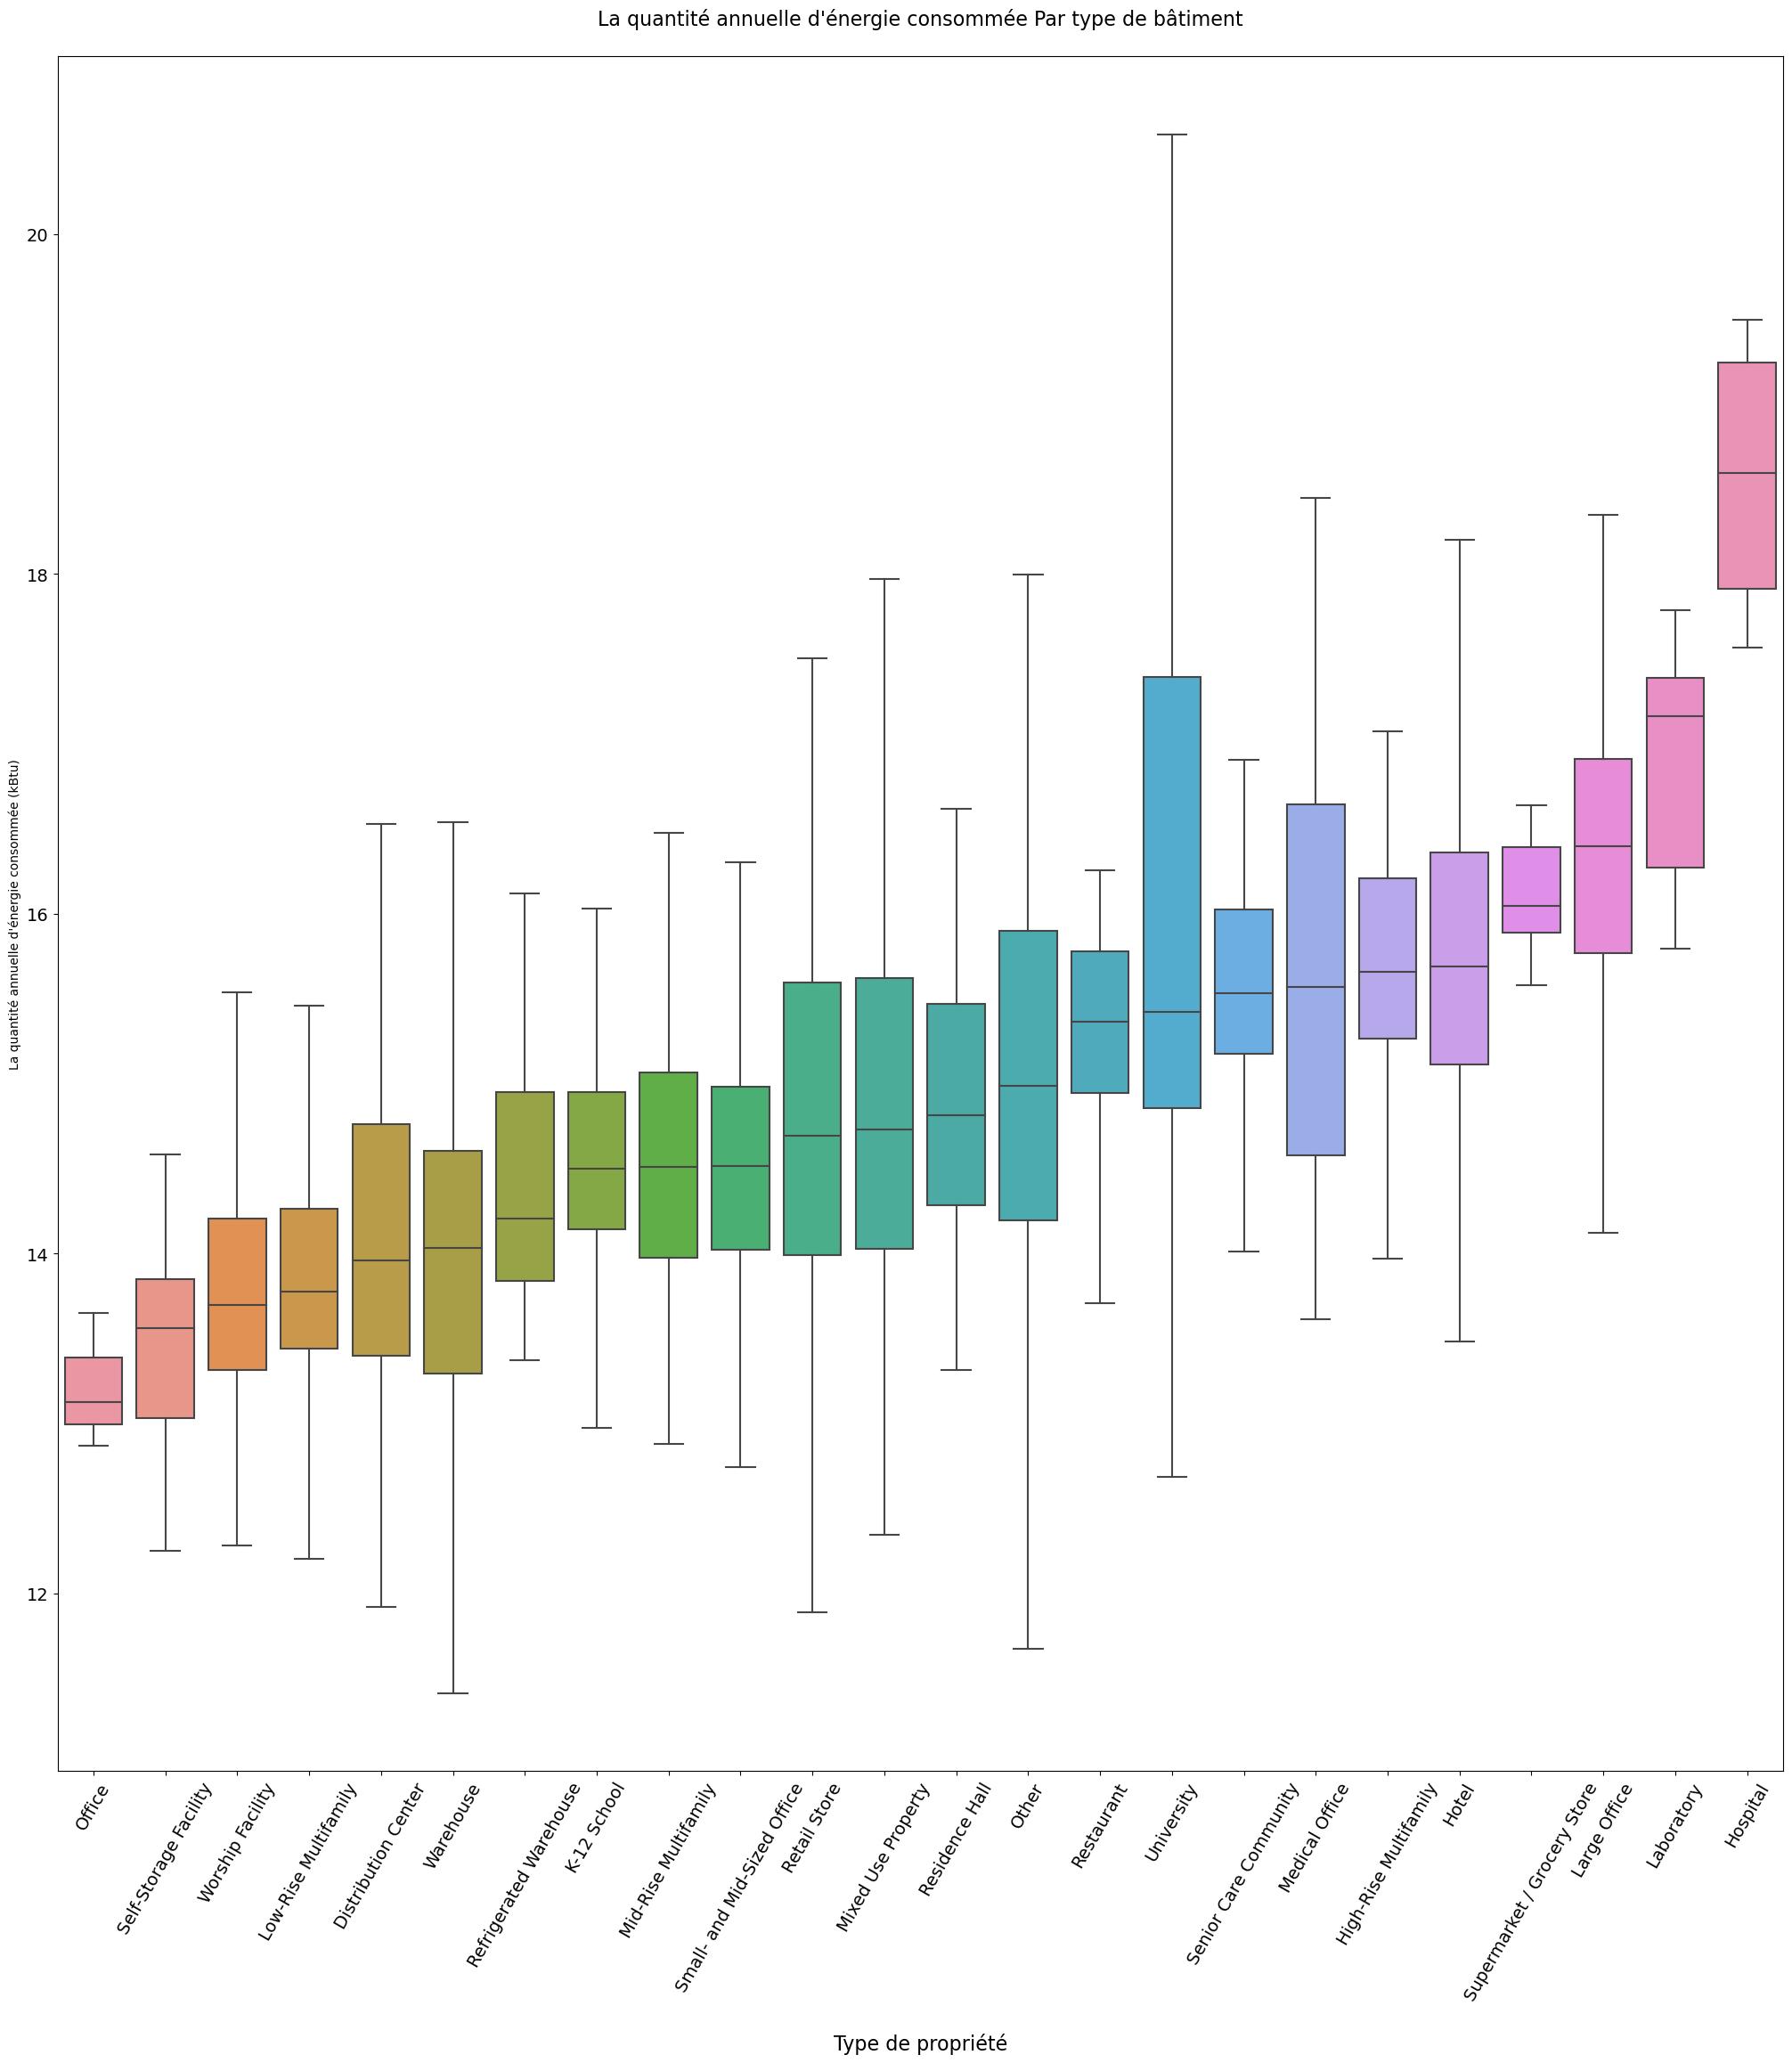

In [19]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


var_y = data['SiteEnergyUse(kBtu)']

grouped = data.loc[:,['PrimaryPropertyType', 'SiteEnergyUse(kBtu)']] \
    .groupby(['PrimaryPropertyType']) \
    .median() \
    .sort_values(by='SiteEnergyUse(kBtu)')



sns.boxplot(x= data['PrimaryPropertyType'], y = np.log(data['SiteEnergyUse(kBtu)']), 
            data =data, order=grouped.index,showfliers=False)

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(25, 25)
ax.set_ylabel("La quantité annuelle d'énergie consommée (kBtu)", fontsize=10)
ax.set_title("La quantité annuelle d'énergie consommée Par type de bâtiment\n", fontsize=16)
plt.xticks(rotation='60', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('\nType de propriété', fontsize=16)

**Représentons les bâtiments par quartier**

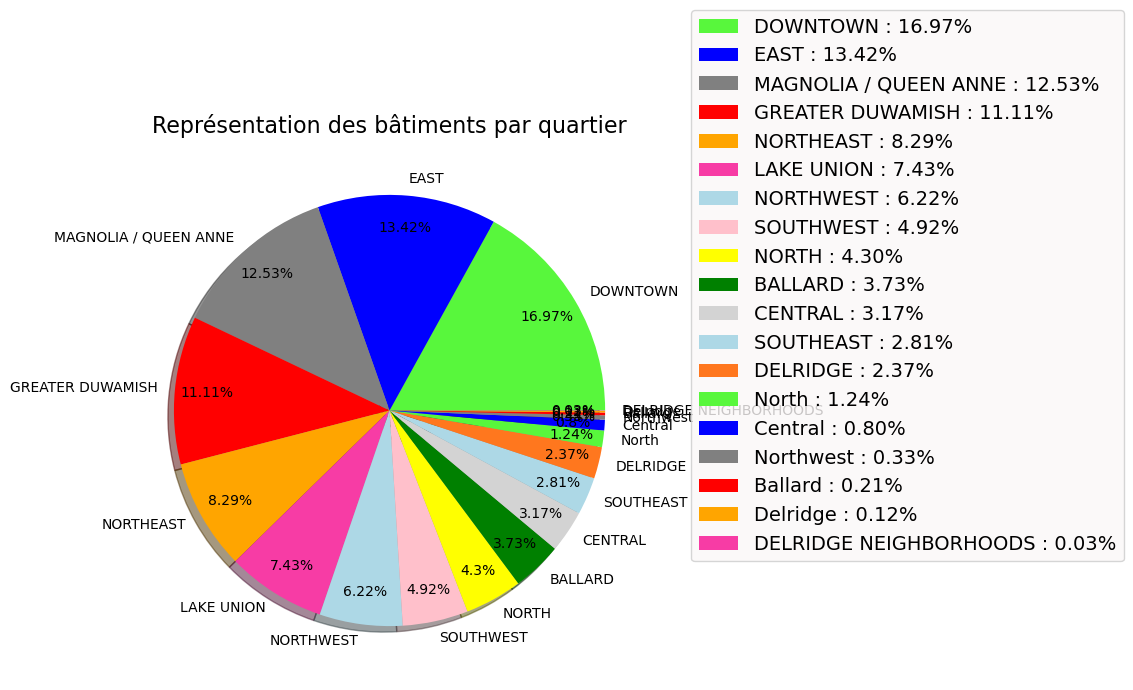

In [20]:
plt.figure(figsize=(10, 7))

y = data['Neighborhood'].value_counts().index
x =data['Neighborhood'].value_counts().values

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow','green', 'lightgray', 'lightblue', '#FF771E']

sns.set_palette(sns.color_palette(colors))

plt.pie(x, labels=y,
        autopct=lambda x: str(round(x, 2)) + '%',
        pctdistance=0.85, labeldistance=1.08,
        shadow=True)

plt.title('Représentation des bâtiments par quartier', fontsize=16)

plt.legend(y, loc=[1.06, 0.22], labels=['%s : %1.2f%%' % (l, s) for l, 
                                        s in zip(y, (x / sum(x)) * 100)],fontsize=14, 
           facecolor='#fbf8f8')

### Analysons les emissions total par type de batiments

Text(0.5, 0, '\nType de propriété')

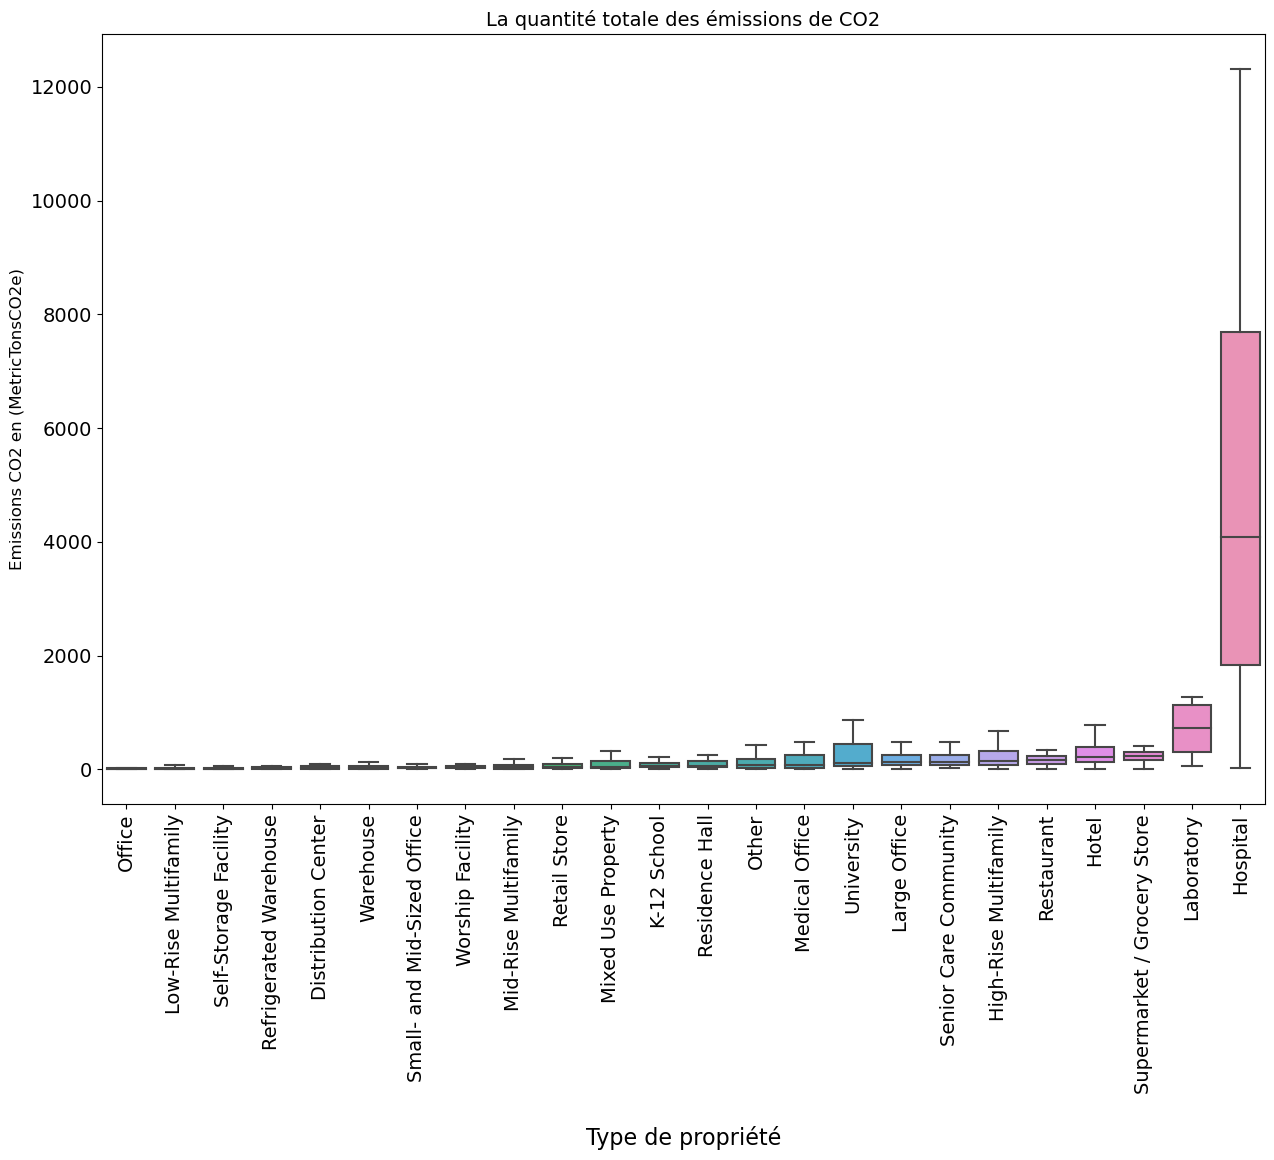

In [21]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


var_y = data['TotalGHGEmissions']

grouped = data.loc[:,['PrimaryPropertyType', 'TotalGHGEmissions']].groupby(['PrimaryPropertyType']) \
    .median() \
    .sort_values(by='TotalGHGEmissions')



sns.boxplot(x= data['PrimaryPropertyType'], y = data['TotalGHGEmissions'], data = data, order=grouped.index,showfliers=False)

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(15, 10)
ax.set_ylabel('Emissions CO2 en (MetricTonsCO2e)', fontsize=12)
ax.set_title("La quantité totale des émissions de CO2", fontsize=14)
plt.xticks(rotation='90', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('\nType de propriété', fontsize=16)

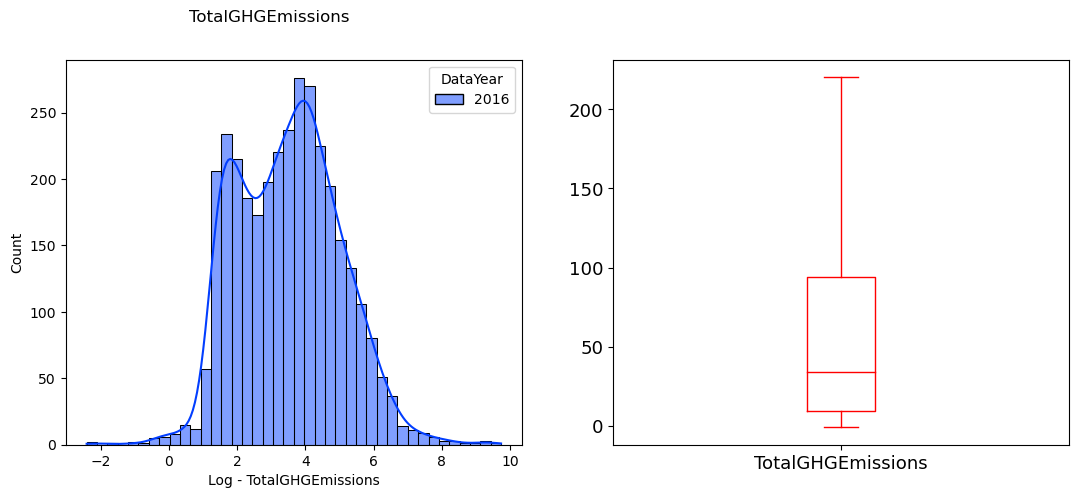

In [22]:
plt.figure(figsize=(20,5))


plt.subplot(132)
#ax = sns.histplot(data=data, x=np.log(data['TotalGHGEmissions']), color='green')
fig = sns.histplot(data=data, x=np.log(data['TotalGHGEmissions']),
                  kde=True, hue='DataYear', palette='bright')

plt.xlabel("Log - TotalGHGEmissions")

plt.subplot(133)
ax = data['TotalGHGEmissions'].plot.box(color='red',showfliers=False)

plt.suptitle("TotalGHGEmissions")

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

## 2. Nettoyage des données

Nous venons de voir qu' il y a beacoupo des defaults. Cette fois nous procedons par les nettoyer avant de faire les predictions

La variable `Comments`, est très peu renseignée , peux être supprimée :

In [23]:
data.drop("Comments", axis=1, inplace=True)

La variable identifiant les outliers peut être interessante pour nos analyses elle correspond au **Si une propriété est une valeur aberrante élevée ou basse (O/N)**, cependant, dans la documentation, nous ne savons pas rééllement à quoi correspondent ces outliers. Nous allons donc supprimer les lignes mentionnant ces outliers.


In [24]:
data = data[~data["Outlier"].isnull()==False]

Maintenant nous effaçons la collone ***Outlier***

In [25]:
data.drop('Outlier', axis=1, inplace=True)

### On a  précisié dans le projet que **seuls les bâtiments non destinés à l'habitation seront étudiés**. Nous allons donc supprimer toutes les lignes correspondant à des habitations en nous basant sur la variable `BuildingType`

**Indentifions d'abord les collonnes qui contiennent les valeurs non numerques**

In [26]:
Columns_object = list(data.dtypes[data.dtypes == np.object].index)

***Indentifions les collonnes qui contiennent les valeurs numerques***

In [27]:
numericColumns = list(data.dtypes[data.dtypes != np.object].index)

In [28]:
print("Le jeu de données compte à présent {} lignes et {} colonnes.".format(data.shape[0],data.shape[1]))

Le jeu de données compte à présent 3344 lignes et 46 colonnes.


***Effacons les doublons***

In [29]:
mean_columns = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
               'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
                'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']


Nous allons également regarder s'il existe des **doublons sur l'identifiant** `OSEBuildingID`. car nos modélisations devront porter sur un bâtiement unique 

In [30]:
OSEBuilding_means = data[['OSEBuildingID']+mean_columns].groupby('OSEBuildingID').mean()
OSEBuilding_means.head()

NumberofBuildings  NumberofFloors  PropertyGFATotal  \
OSEBuildingID                                                        
1                            1.0            12.0           88434.0   
2                            1.0            11.0          103566.0   
3                            1.0            41.0          956110.0   
5                            1.0            10.0           61320.0   
8                            1.0            18.0          175580.0   

               PropertyGFAParking  PropertyGFABuilding(s)  \
OSEBuildingID                                               
1                             0.0                 88434.0   
2                         15064.0                 88502.0   
3                        196718.0                759392.0   
5                             0.0                 61320.0   
8                         62000.0                113580.0   

               LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
OSEBuildingID                                                               
1                                88434.0                              NaN   
2                                83880.0                          15064.0   
3                               756493.0                              NaN   
5                                61320.0                              NaN   
8                               123445.0                          68009.0   

               ThirdLargestPropertyUseTypeGFA  ENERGYSTARScore  \
OSEBuildingID                                                    
1                                         NaN             60.0   
2                                      4622.0             61.0   
3                                         NaN             43.0   
5                                         NaN             56.0   
8                                         0.0             75.0   

               SiteEUI(kBtu/sf)  ...  SourceEUI(kBtu/sf)  \
OSEBuildingID                    ...                       
1                     81.699997  ...          182.500000   
2                     94.800003  ...          176.100006   
3                     96.000000  ...          241.899994   
5                    110.800003  ...          216.199997   
8                    114.800003  ...          211.399994   

               SourceEUIWN(kBtu/sf)  SiteEnergyUse(kBtu)  \
OSEBuildingID                                              
1                        189.000000            7226362.5   
2                        179.399994            8387933.0   
3                        244.100006           72587024.0   
5                        224.000000            6794584.0   
8                        215.600006           14172606.0   

               SiteEnergyUseWN(kBtu)  Electricity(kWh)  Electricity(kBtu)  \
OSEBuildingID                                                               
1                          7456910.0      1.156514e+06          3946027.0   
2                          8664479.0      9.504252e+05          3242851.0   
3                         73937112.0      1.451544e+07         49526664.0   
5                          6946800.5      8.115253e+05          2768924.0   
8                         14656503.0      1.573449e+06          5368607.0   

               NaturalGas(therms)  NaturalGas(kBtu)  TotalGHGEmissions  \
OSEBuildingID                                                            
1                     12764.52930         1276453.0             249.98   
2                     51450.81641         5145082.0             295.86   
3                     14938.00000         1493800.0            2089.28   
5                     18112.13086         1811213.0             286.43   
8                     88039.98438         8803998.0             505.01   

               GHGEmissionsIntensity  
OSEBuildingID                         
1                               2.83  
2                               2.86  
3                               2.19

In [31]:
duplicate_building = data.drop_duplicates(subset=['OSEBuildingID'], keep='last')
duplicate_building.drop(mean_columns, axis=1, inplace=True)
data = pd.merge(duplicate_building, OSEBuilding_means, how='left', on='OSEBuildingID')

Dans la visualisation ci-dessus, certaines variables apparaissent déjà comme redondantes :
- `Electricity(kWh)` et `Electricity(kBtu)`,
- `NaturalGas(therms)` et `NaturalGas(kBtu)`
- Les suffixes **WN** : "Weather Normalized" - Ce sont les mesures normalisées avec les conditions climatiques. Dans le cadre de notre analyse, la météo ne rentrera pas en compte.

Nous allons donc commencer par supprimer ces variables :

In [32]:
def search_componant(df, suffix=None):
  componant = []
  for col in df.columns:
      if suffix in col: 
        componant.append(col)
  return componant

**Supprimons les variables avec WN**

In [33]:
data.drop(search_componant(data,'WN'), axis=1, inplace=True)

**Supprimons les variables redondantes**

In [34]:
redundant_features = ['NaturalGas(therms)','Electricity(kWh)']
data.drop(redundant_features, axis=1, inplace=True)

In [35]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3344.000000    3344.0   3328.000000          3344.000000   
mean    21188.288876    2016.0  98116.984375             4.444976   
std     12229.772762       0.0     18.672612             2.117677   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19989.500000    2016.0  98105.000000             3.000000   
50%     23108.500000    2016.0  98115.000000             4.000000   
75%     25992.500000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude    YearBuilt  SteamUse(kBtu)  \
count  3344.000000  3344.000000  3344.000000    3.335000e+03   
mean     47.624216  -122.334741  1968.745813    2.746206e+05   
std       0.047813     0.027195    33.005479    3.928102e+06   
min      47.499170  -122.414250  1900.000000    0.000000e+00   
25%      47.600180  -122.350552  1948.750000    0.000000e+00   
50%      47.618875  -122.332475  1975.000000    0.000000e+00   
75%      47.657293  -122.319345  1997.000000    0.000000e+00   
max      47.733870  -122.220966  2015.000000    1.349435e+08   

       Energy_use_par_area  Energy_Source_proportion  ...  \
count          3339.000000               3317.000000  ...   
mean             50.923584                       inf  ...   
std              56.111204                       NaN  ...   
min               0.000000                  7.288874  ...   
25%              25.187985                 31.864755  ...   
50%              35.502988                 37.547031  ...   
75%              54.905886                 46.288950  ...   
max             906.130957                       inf  ...   

       SecondLargestPropertyUseTypeGFA  ThirdLargestPropertyUseTypeGFA  \
count                      1663.000000                      589.000000   
mean                      28556.825795                    11814.484548   
std                       54587.821013                    29483.416793   
min                           0.000000                        0.000000   
25%                        5000.000000                     2351.000000   
50%                       10751.000000                     5100.000000   
75%                       26770.000000                    10270.000000   
max                      686750.000000                   459748.000000   

       ENERGYSTARScore  SiteEUI(kBtu/sf)  SourceEUI(kBtu/sf)  \
count      2510.000000       3337.000000         3335.000000   
mean         67.829482         54.716782          134.184978   
std          26.707896         55.910975          137.785292   
min           1.000000          0.000000            0.000000   
25%          53.000000         28.100000           75.000000   
50%          75.000000         38.700001           96.400002   
75%          90.000000         60.400002          143.849998   
max         100.000000        834.400024         2620.000000   

       SiteEnergyUse(kBtu)  Electricity(kBtu)  NaturalGas(kBtu)  \
count         3.339000e+03       3.335000e+03      3.335000e+03   
mean          5.414823e+06       3.714747e+06      1.374779e+06   
std           2.169684e+07       1.490014e+07      6.739079e+06   
min           0.000000e+00      -1.154170e+05      0.000000e+00   
25%           9.351888e+05       6.440895e+05      0.000000e+00   
50%           1.809102e+06       1.183042e+06      3.294020e+05   
75%           4.218830e+06       2.835446e+06      1.193214e+06   
max           8.739237e+08       6.570744e+08      2.979090e+08   

       TotalGHGEmissions  GHGEmissionsIntensity  
count        3335.000000            3335.000000  
mean          120.108843               1.174963  
std           541.164241               1.813405  
min            -0.800000              -0.020000  
25%             9.655000               0.210000  
50%            34.110000               0.620000  
75%            94.015000               1.370000  
max       

On remarque également des variables suffixées **GFA** : Elle représente la surface au sol *(Ground Floor Area)*. Nous les conservons donc pour la suite des analyses.

Dans le cadre de nos modélisations, les variables à prédire sont la **consommation d'énergie du bâtiment** (`SiteEnergyUse(kBtu)`) et ses **émissions de CO2** (`TotalGHGEmissions`). Certaines lignes comportent des manquants sur ces variables, nous allons donc les supprimer :

In [36]:
data = data[~((data['SiteEnergyUse(kBtu)'].isnull()) | (data['TotalGHGEmissions'].isnull()))]

## 2. Regardons la répartition des divers types de bâtiments à étudier :

#### 2.1. Les types de bâtiments

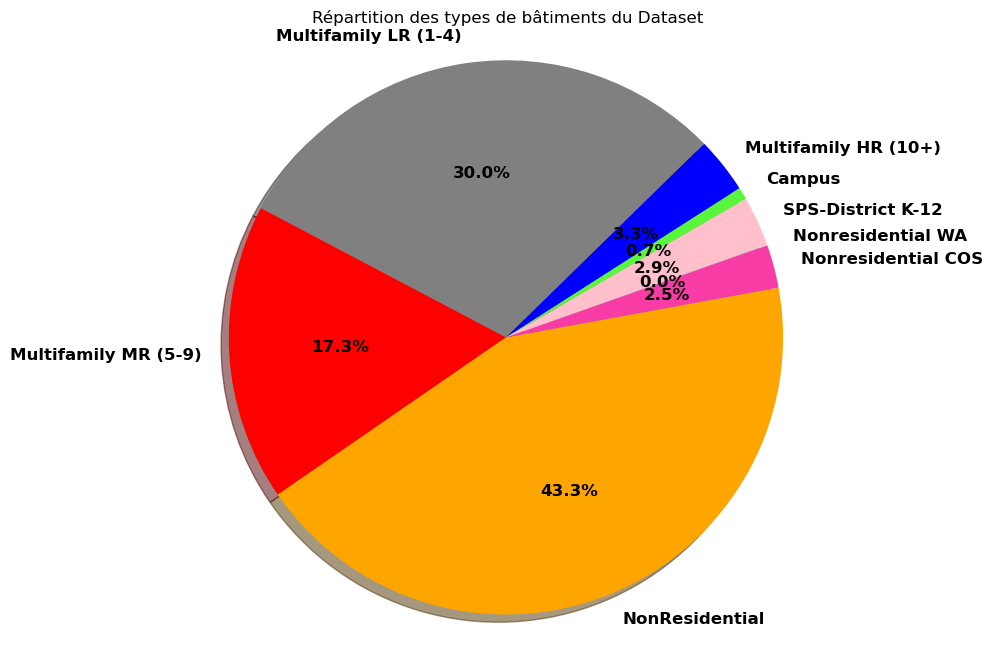

In [37]:
building_type = data.groupby(by='BuildingType')['OSEBuildingID'].nunique()

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du Dataset")
plt.show()

#### La majeur partie des bâtiments sont typés **"NonResidential"**. Nous pouvons visualiser les diverses catégories représentées dans ce type de bâtiments :

In [38]:
data.loc[(data['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    284
Other                          183
Warehouse                      180
Large Office                   165
Mixed Use Property             101
Retail Store                    89
Hotel                           75
Worship Facility                69
Distribution Center             51
Supermarket / Grocery Store     40
Medical Office                  38
K-12 School                     38
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

###  2.2. Les années de construction des bâtiments
Regardons les distribution des années de construction des bâtiments de Seattle :

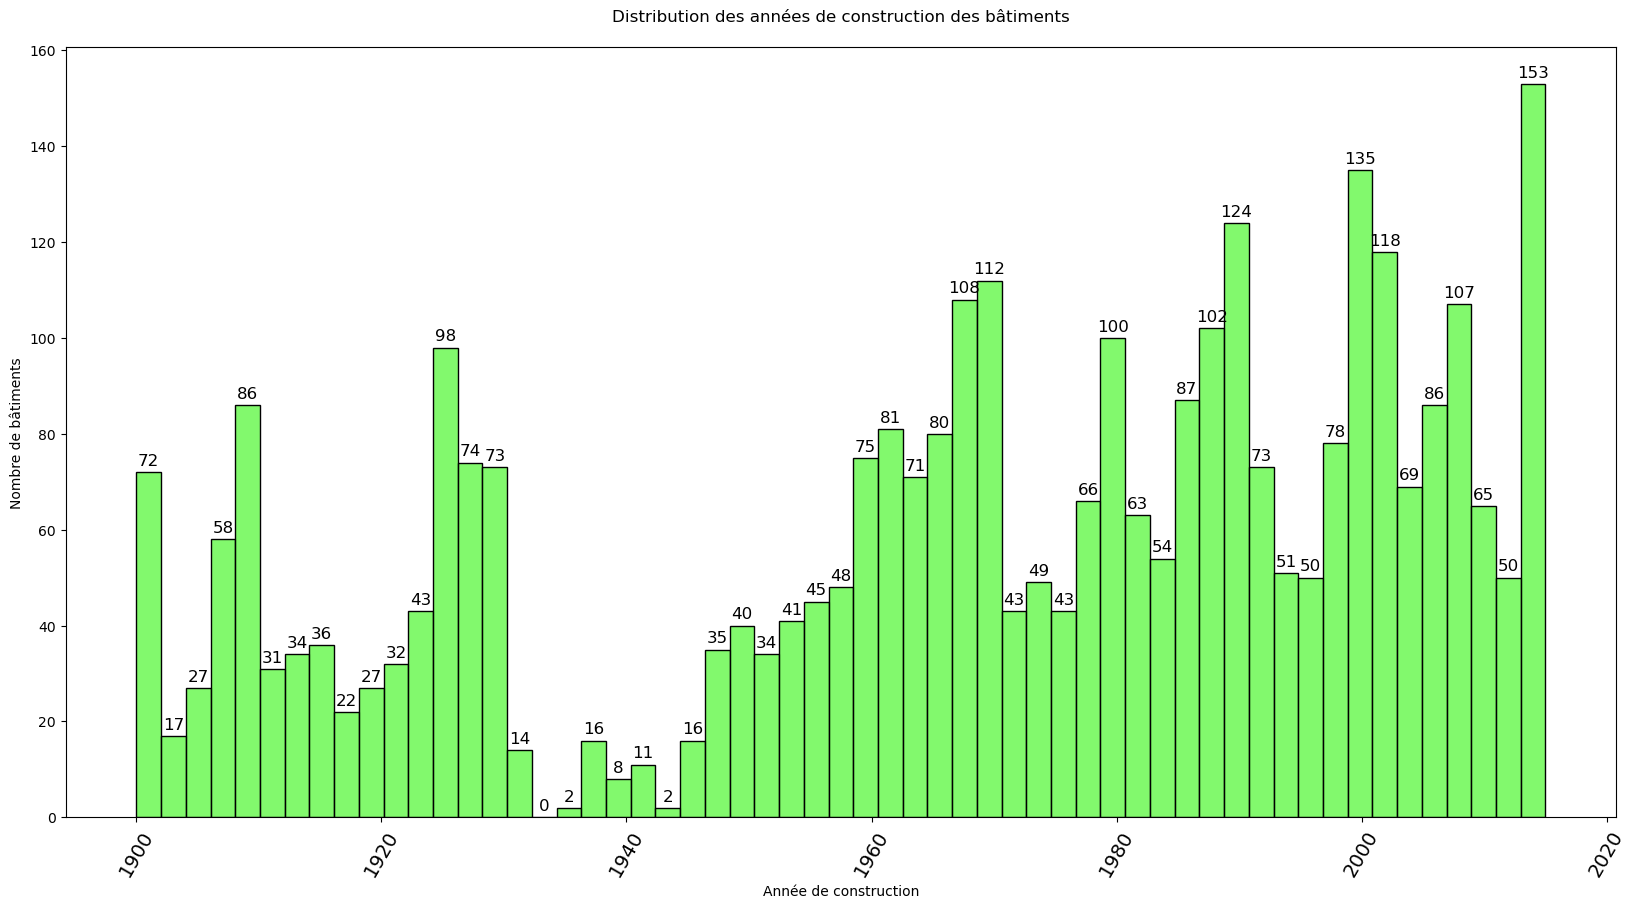

In [39]:
fig = plt.figure(figsize=(20,10))
ax = sns.histplot(data=data, x='YearBuilt', bins=int((data.YearBuilt.max() - data.YearBuilt.min())/2))

# Ajouter les annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 12,
                )
    plt.xticks(rotation='60', fontsize=14)

ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n")
plt.show()

##### Ici on traite l'**age des bâtiments** pour réduire la dispersion des données et lier l'année des relevés. Nous allons donc créer cette nouvelle variable et supprimer l'année de construction :

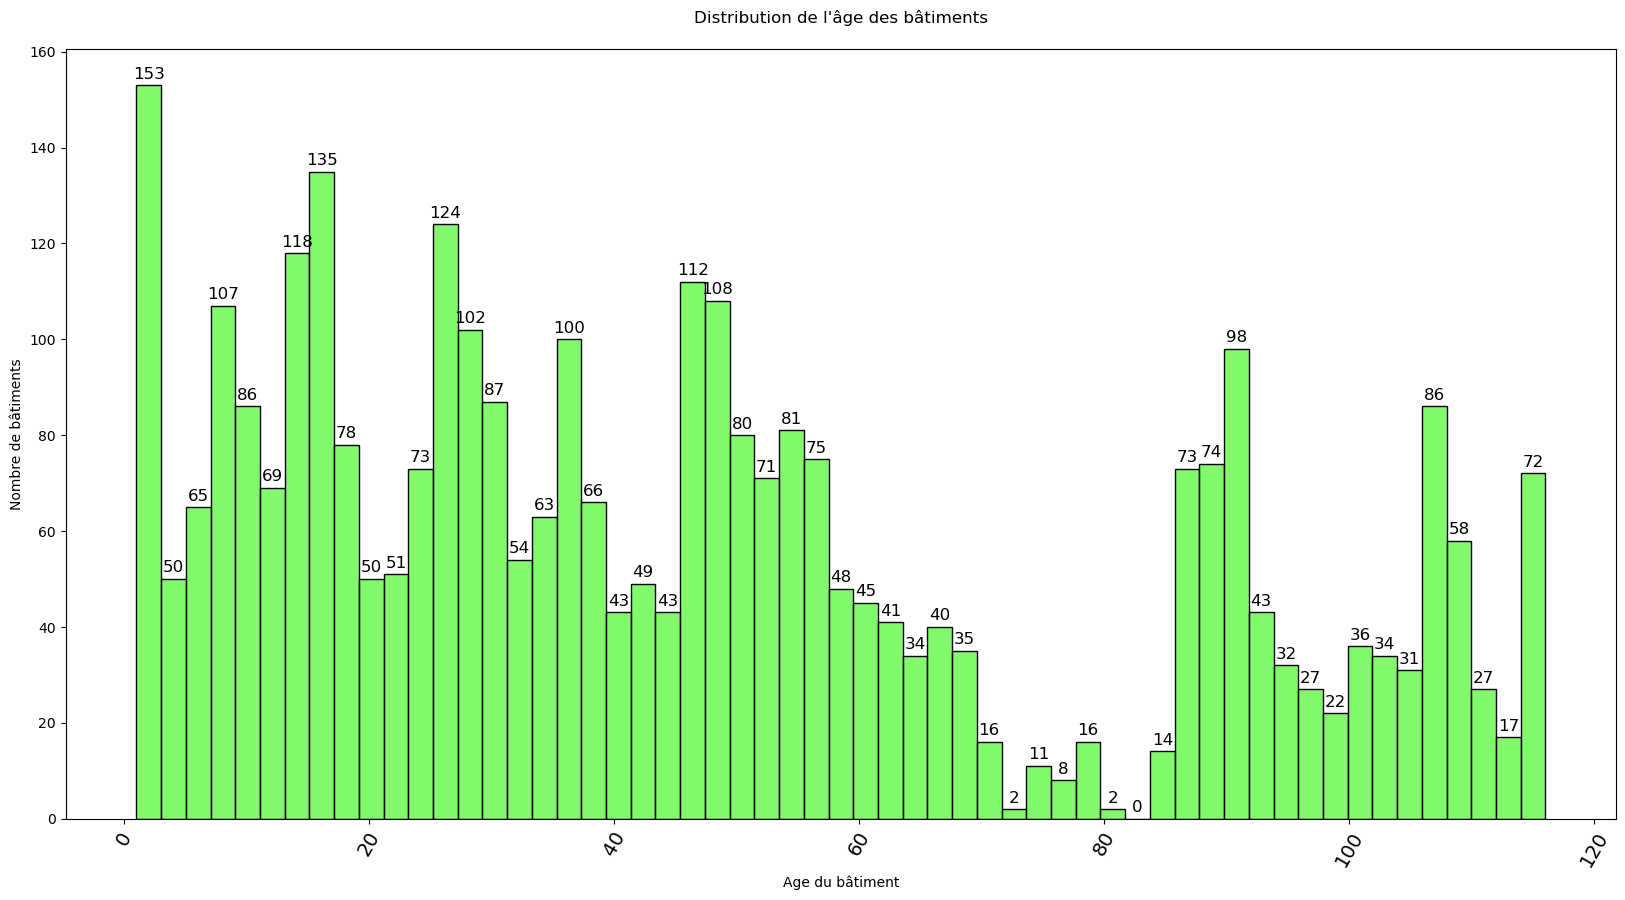

In [40]:
data['BuildingAge'] = data['DataYear'] - data['YearBuilt']
data.drop('YearBuilt', axis=1, inplace=True)
fig = plt.figure(figsize=(20,10))
ax = sns.histplot(data=data, x='BuildingAge', bins=int((data.BuildingAge.max() - data.BuildingAge.min())/2))

# Ajouter les annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 12,
                )
    plt.xticks(rotation='60', fontsize=14)
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n")
plt.show()

Pour le YearBuilt, en gardant l'année on va faire trop de features quand on applique le one-hot encoder). En plus,posons nous cette question: quelle est la différence entre un bâtiment construit en 2010 et un autre en 2011 ? et pareil, un bâtiment construit en 2000 et un autre en 2010 ?

Donc prendre l'année ça ne nous aidera pas à améliorer le modèle. On  peut réduire à 10 ans.

In [41]:
def condition(x):
    interv=np.arange(0,120,5)
    for i in interv:
        if x<i+10 and x>i:
            return i
data['BuildingAge_rescaled'] = data['BuildingAge'].apply(condition)
data=data.drop('BuildingAge',axis=1) 

###  2.3. Les corrélations linéaires entre les variables

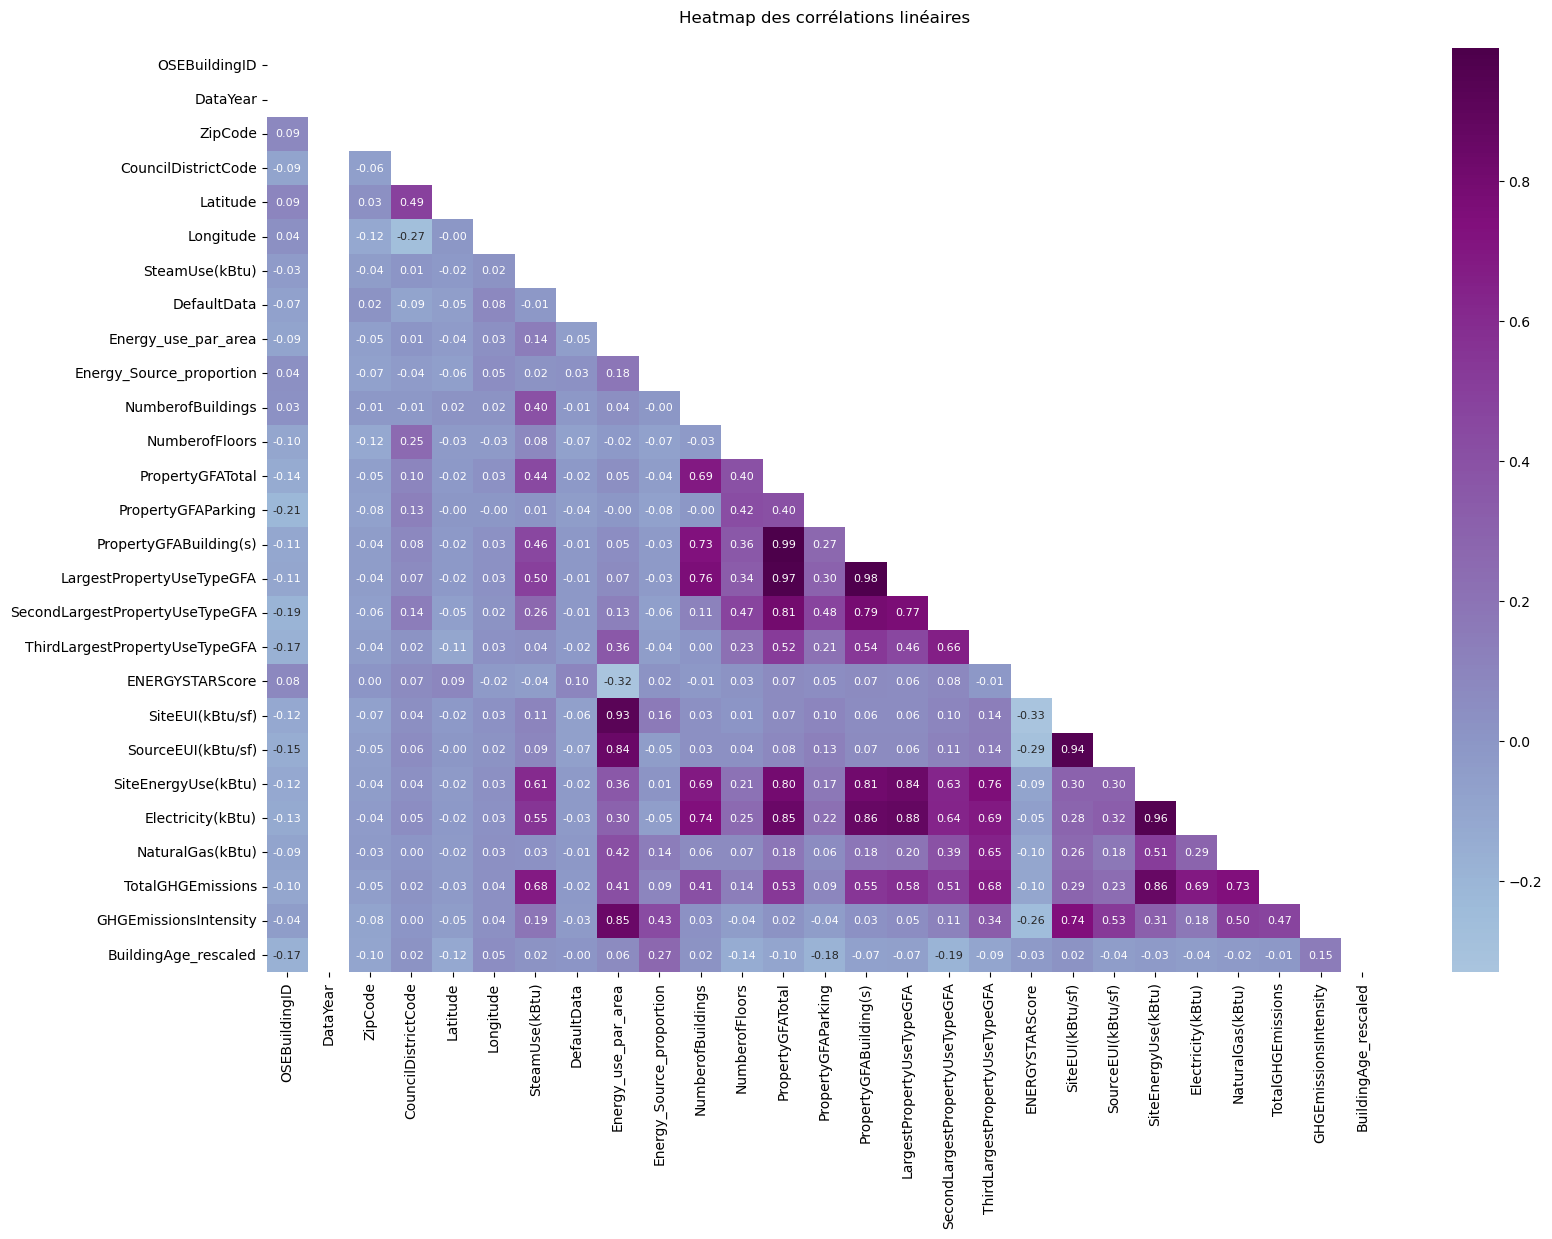

In [42]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(18,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="BuPu")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

Pour les varaibles à prédire `TotalGHGEmissions` et `SiteEnergyUse(kBtu)`, on remarque des corrélations linéaires quasi similaires avec les variables de relevés (les consommations) mais également avec le nombre de batiments ou d'étages ains que les surfaces au sol. 

On remarque sur ce Heatmap de fortes corrélations linéaires entre variables. Ces corrélations peuvent amener des problèmes de colinéarité dans nos futurs modèles. Isolons donc les **paires de variables avec des corrélations de Pearson supérieurs à 0.7** :

In [43]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0                          level_1  \
46           PropertyGFABuilding(s)                 PropertyGFATotal   
44           PropertyGFABuilding(s)        LargestPropertyUseTypeGFA   
42                 PropertyGFATotal        LargestPropertyUseTypeGFA   
40              SiteEnergyUse(kBtu)                Electricity(kBtu)   
38                 SiteEUI(kBtu/sf)               SourceEUI(kBtu/sf)   
36                 SiteEUI(kBtu/sf)              Energy_use_par_area   
34                Electricity(kBtu)        LargestPropertyUseTypeGFA   
32              SiteEnergyUse(kBtu)                TotalGHGEmissions   
30                Electricity(kBtu)           PropertyGFABuilding(s)   
28                 PropertyGFATotal                Electricity(kBtu)   
26              Energy_use_par_area            GHGEmissionsIntensity   
24               SourceEUI(kBtu/sf)              Energy_use_par_area   
22              SiteEnergyUse(kBtu)        LargestPropertyUseTypeGFA   
20              SiteEnergyUse(kBtu)           PropertyGFABuilding(s)   
18  SecondLargestPropertyUseTypeGFA                 PropertyGFATotal   
16              SiteEnergyUse(kBtu)                 PropertyGFATotal   
14           PropertyGFABuilding(s)  SecondLargestPropertyUseTypeGFA   
12  SecondLargestPropertyUseTypeGFA        LargestPropertyUseTypeGFA   
10        LargestPropertyUseTypeGFA                NumberofBuildings   
8    ThirdLargestPropertyUseTypeGFA              SiteEnergyUse(kBtu)   
6                 NumberofBuildings                Electricity(kBtu)   
4             GHGEmissionsIntensity                 SiteEUI(kBtu/sf)   
2                 TotalGHGEmissions                 NaturalGas(kBtu)   
0                 NumberofBuildings           PropertyGFABuilding(s)   

    corr_coeff  
46    0.989823  
44    0.978448  
42    0.974150  
40    0.956670  
38    0.943898  
36    0.925029  
34    0.876168  
32    0.863001  
30    0.860779  
28    0.850378  
26    0.848735  
24    0.844918  
22    0.836629  
20    0.812229  
18    0.807507  
16    0.797056  
14    0.791780  
12    0.769202  
10    0.759022  
8     0.755113  
6     0.736567  
4     0.735452  
2     0.732376  
0     0.730879

Notez que les variables suffixées GFA montrent de fortes corrélations avec plusieurs autres variables. Nous allons donc **créer de nouvelles variables** pour tenter d'effacer ces corrélations linéaires :

##### Nous allons à présent convertir les différentes surfaces (Buildings et Parking) en **pourcentage de la surface totale** et nous conserverons uniquement ces 2 variables en supprimant les variables `LargestPropertyUseTypeGFA`, `SecondLargestPropertyUseTypeGFA`, `ThirdLargestPropertyUseTypeGFA` :

In [44]:
gfa_features = search_componant(data, suffix='GFA')
data[gfa_features].head(10)

PropertyGFATotal  PropertyGFAParking  PropertyGFABuilding(s)  \
0           88434.0                 0.0                 88434.0   
1          103566.0             15064.0                 88502.0   
2          956110.0            196718.0                759392.0   
3           61320.0                 0.0                 61320.0   
4          175580.0             62000.0                113580.0   
5           97288.0             37198.0                 60090.0   
6           83008.0                 0.0                 83008.0   
7          102761.0                 0.0                102761.0   
8          163984.0                 0.0                163984.0   
9           63712.0              1496.0                 62216.0   

   LargestPropertyUseTypeGFA  SecondLargestPropertyUseTypeGFA  \
0                    88434.0                              NaN   
1                    83880.0                          15064.0   
2                   756493.0                              NaN   
3                    61320.0                              NaN   
4                   123445.0                          68009.0   
5                    88830.0                              NaN   
6                    81352.0                              NaN   
7                   102761.0                              NaN   
8                   163984.0                              NaN   
9                    56132.0                              NaN   

   ThirdLargestPropertyUseTypeGFA  
0                             NaN  
1                          4622.0  
2                             NaN  
3                             NaN  
4                             0.0  
5                             NaN  
6                             NaN  
7                             NaN  
8                             NaN  
9                             NaN

In [45]:
#On calcule les ratios
data['GFABuildingNormalised'] = (round((data['PropertyGFABuilding(s)'].fillna(0)
                                  /data['PropertyGFATotal'].fillna(0)),5))
data['GFAParkingNormalised'] = (round((data['PropertyGFAParking'].fillna(0)
                                 /data['PropertyGFATotal'].fillna(0)),5))

#On supprime les variables inutiles
data.drop(['LargestPropertyUseTypeGFA', 
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'PropertyGFAParking',
           'PropertyGFABuilding(s)'],
         axis=1, inplace=True)


#On complète les usages de la partie la plus large
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna("Unknown")
data['NumberofFloors'] = data['NumberofFloors'].fillna(1)



In [46]:
GFAD=search_componant(data, suffix='GFA')
data[GFAD].head(10)

PropertyGFATotal  GFABuildingNormalised  GFAParkingNormalised
0           88434.0                1.00000               0.00000
1          103566.0                0.85455               0.14545
2          956110.0                0.79425               0.20575
3           61320.0                1.00000               0.00000
4          175580.0                0.64688               0.35312
5           97288.0                0.61765               0.38235
6           83008.0                1.00000               0.00000
7          102761.0                1.00000               0.00000
8          163984.0                1.00000               0.00000
9           63712.0                0.97652               0.02348

Nous pouvons également calculer la **surface moyenne par bâtiment et par étage** :

In [47]:
data['GFAPerBuilding'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),3)
data['GFAPerFloor'] = round((data['PropertyGFATotal'] / data['NumberofFloors']),3)

In [48]:
data.describe()

OSEBuildingID  DataYear       ZipCode  CouncilDistrictCode  \
count    3335.000000    3335.0   3319.000000          3335.000000   
mean    21179.224888    2016.0  98116.995782             4.445877   
std     12229.701712       0.0     18.689477             2.117569   
min         1.000000    2016.0  98006.000000             1.000000   
25%     19989.000000    2016.0  98105.000000             3.000000   
50%     23106.000000    2016.0  98115.000000             4.000000   
75%     25993.000000    2016.0  98122.000000             7.000000   
max     50226.000000    2016.0  98272.000000             7.000000   

          Latitude    Longitude  SteamUse(kBtu)  Energy_use_par_area  \
count  3335.000000  3335.000000    3.335000e+03          3335.000000   
mean     47.624192  -122.334740    2.746206e+05            50.953741   
std       0.047816     0.027163    3.928102e+06            56.137735   
min      47.499170  -122.414250    0.000000e+00             0.000000   
25%      47.600150  -122.350505    0.000000e+00            25.194213   
50%      47.618820  -122.332470    0.000000e+00            35.518665   
75%      47.657215  -122.319395    0.000000e+00            54.962073   
max      47.733870  -122.220966    1.349435e+08           906.130957   

       Energy_Source_proportion  NumberofBuildings  ...  SiteEnergyUse(kBtu)  \
count               3317.000000        3335.000000  ...         3.335000e+03   
mean                        inf           1.106447  ...         5.420357e+06   
std                         NaN           2.117656  ...         2.170926e+07   
min                    7.288874           0.000000  ...         0.000000e+00   
25%                   31.864755           1.000000  ...         9.360823e+05   
50%                   37.547031           1.000000  ...         1.811506e+06   
75%                   46.288950           1.000000  ...         4.222455e+06   
max                         inf         111.000000  ...         8.739237e+08   

       Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
count       3.335000e+03      3.335000e+03        3335.000000   
mean        3.714747e+06      1.374779e+06         120.108843   
std         1.490014e+07      6.739079e+06         541.164241   
min        -1.154170e+05      0.000000e+00          -0.800000   
25%         6.440895e+05      0.000000e+00           9.655000   
50%         1.183042e+06      3.294020e+05          34.110000   
75%         2.835446e+06      1.193214e+06          94.015000   
max         6.570744e+08      2.979090e+08       16870.980000   

       GHGEmissionsIntensity  BuildingAge_rescaled  GFABuildingNormalised  \
count            3335.000000           3335.000000            3335.000000   
mean                1.174963             40.574213               0.958370   
std                 1.813405             32.760540               0.115119   
min                -0.020000              0.000000               0.104980   
25%                 0.210000             10.000000               1.000000   
50%                 0.620000             35.000000               1.000000   
75%                 1.370000             60.000000               1.000000   
max                34.090000            110.000000               1.000000   

       GFAParkingNormalised  GFAPerBuilding  GFAPerFloor  
count           3335.000000          3335.0     3335.000  
mean               0.041630             inf          inf  
std                0.115119             NaN          NaN  
min                0.000000          4300.0      221.697  
25%                0.000000         28186.0     8664.667  
50%                0.000000         44416.0    14054.500  
75%                0.000000         94440.0    26445.250  
max                0.895020             inf          inf  

[8 rows x 25 columns]

### Dans cette description, on remarque des données avec des **valeurs infinie**. Nous allons regarder de plus prêt ces données et les corriger :

In [49]:
data[(data.GFAPerBuilding == np.inf) | (data.GFAPerFloor == np.inf)].head()

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
63              89      2016  NonResidential               Medical Office   
76             113      2016  NonResidential  Small- and Mid-Sized Office   
160            257      2016  NonResidential                    Warehouse   
166            267      2016  NonResidential                        Hotel   
201            322      2016  NonResidential                 Large Office   

                              PropertyName           Address     City State  \
63               Polyclinic North && South  1200 Harvard Ave  Seattle    WA   
76                                   KCTS9     401 Mercer St  Seattle    WA   
160  Harbor Island: Warehouse E - DNRP-SWD  3235 16TH AVE SW  Seattle    WA   
166                    Grand Hyatt Seattle       721 Pine St  Seattle    WA   
201  Cox Media Group Seattle KIRO TV (322)      2801 3rd Ave  Seattle    WA   

     ZipCode TaxParcelIdentificationNumber  ...  SiteEnergyUse(kBtu)  \
63   98122.0                    1978201270  ...          16701055.00   
76   98109.0                    1988200705  ...           4166306.25   
160  98134.0                    7666703020  ...           2411402.25   
166  98101.0                    6792120000  ...          65047284.00   
201  98121.0                    0656000005  ...           9788717.00   

    Electricity(kBtu)  NaturalGas(kBtu)  TotalGHGEmissions  \
63          9886484.0         6814570.0             430.84   
76          4166305.0               0.0              29.04   
160         2411402.0               0.0              16.81   
166        39364114.0        25683162.0            1638.46   
201         9788716.0               0.0              68.24   

    GHGEmissionsIntensity BuildingAge_rescaled GFABuildingNormalised  \
63                   2.41                   45               1.00000   
76                   0.44                   25               0.96449   
160                  0.21                   95               1.00000   
166                  1.75                   10               1.00000   
201                  0.68                   40               0.73464   

    GFAParkingNormalised  GFAPerBuilding  GFAPerFloor  
63               0.00000             inf    59671.333  
76               0.03551             inf    33120.000  
160              0.00000             inf    19900.000  
166              0.00000        934292.0          inf  
201              0.26536             inf    33578.000  

[5 rows x 39 columns]

Remplacons les inf par les Nan

In [50]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)

Les données sont à présent bien complétées. Nous allons vérifier l'impact de ce feature engineering sur la matrice des corrélations linéaires :

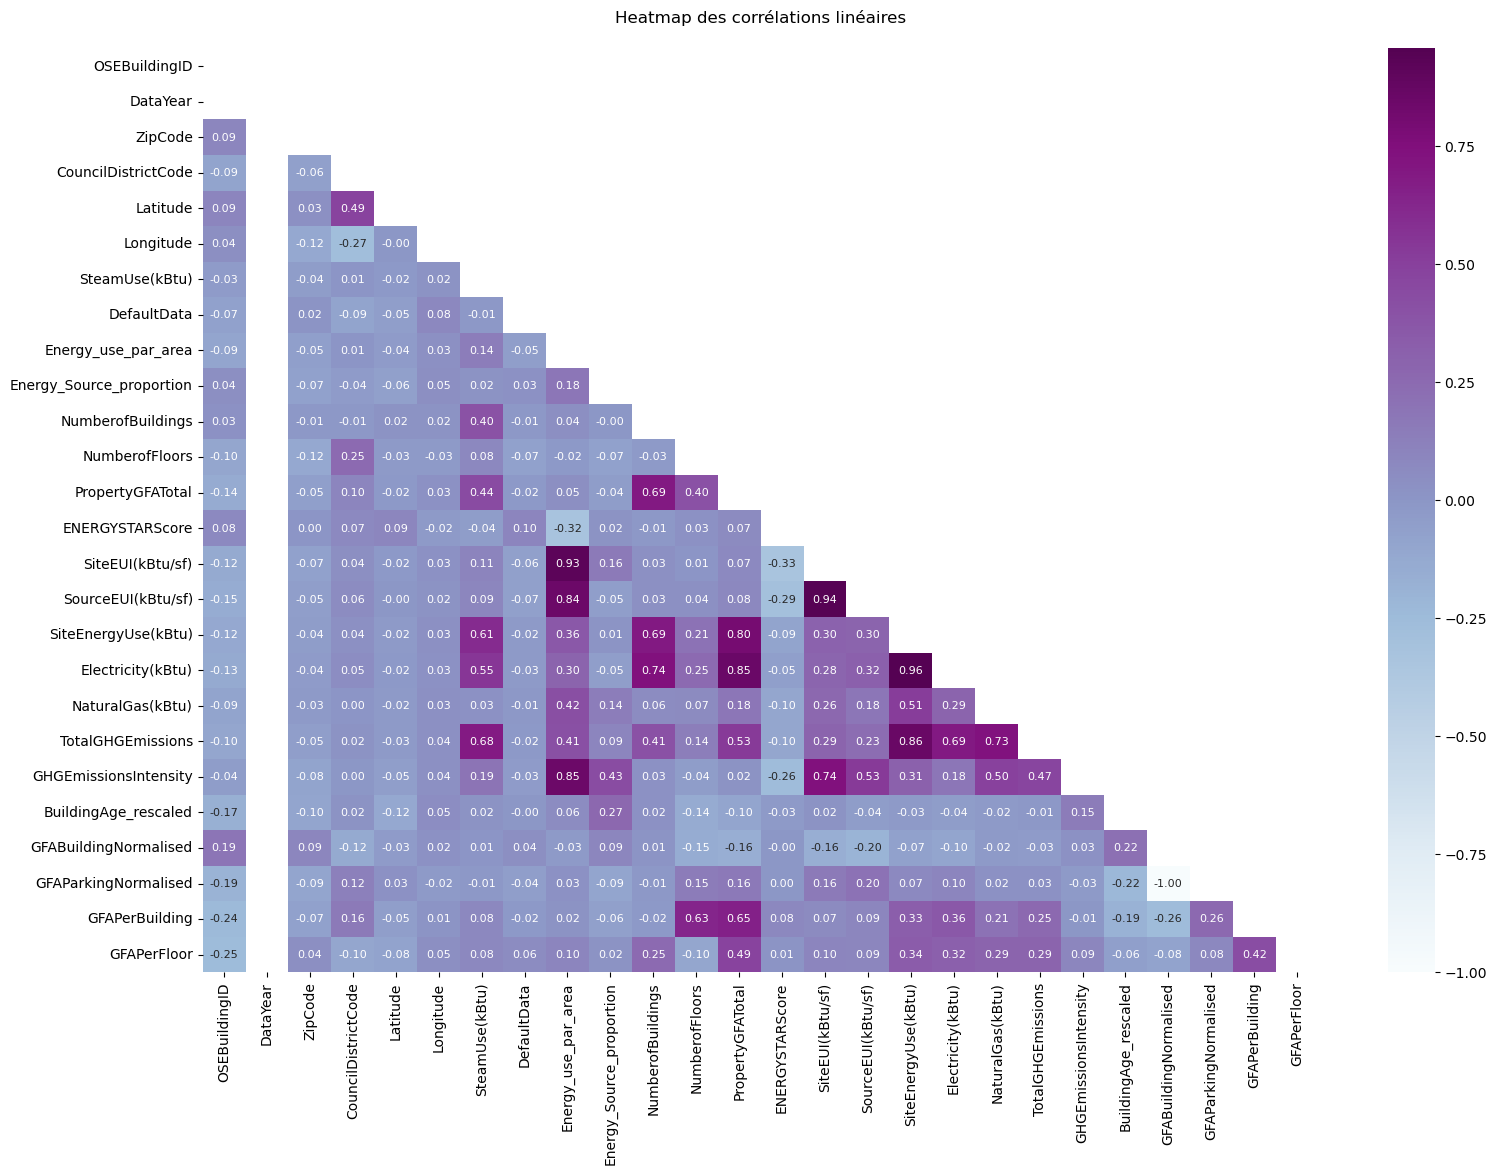

In [51]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(18,12))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="BuPu")
plt.title(f"Heatmap des corrélations linéaires\n")
plt.show()

In [52]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0                level_1  corr_coeff
22      Electricity(kBtu)    SiteEnergyUse(kBtu)    0.956670
20       SiteEUI(kBtu/sf)     SourceEUI(kBtu/sf)    0.943898
18    Energy_use_par_area       SiteEUI(kBtu/sf)    0.925029
16    SiteEnergyUse(kBtu)      TotalGHGEmissions    0.863001
14       PropertyGFATotal      Electricity(kBtu)    0.850378
12    Energy_use_par_area  GHGEmissionsIntensity    0.848735
10    Energy_use_par_area     SourceEUI(kBtu/sf)    0.844918
8        PropertyGFATotal    SiteEnergyUse(kBtu)    0.797056
6       Electricity(kBtu)      NumberofBuildings    0.736567
4        SiteEUI(kBtu/sf)  GHGEmissionsIntensity    0.735452
2        NaturalGas(kBtu)      TotalGHGEmissions    0.732376
0   GFABuildingNormalised   GFAParkingNormalised   -1.000000

Ici on voit aussi que electicity **Electricity(kBtu)** est fortement correlé aux variables à predire.
Pour reduire cette correlation on va remplace ***Electricity(kBtu*** par ***Electricity(kBtu/energie total*** . Ça va egalement pour **NaturalGas(kBtu)**

In [53]:
data['Electricity_ratio'] = (round((data['Electricity(kBtu)'].fillna(0)
                                 /data['SiteEnergyUse(kBtu)'].fillna(0)),5)) 

data['Natural_gas_ratio'] = (round((data['NaturalGas(kBtu)'].fillna(0)
                                 /data['SiteEnergyUse(kBtu)'].fillna(0)),5)) 


data['SteamUse_ratio'] = (round((data['SteamUse(kBtu)'].fillna(0)
                                 /data['SiteEnergyUse(kBtu)'].fillna(0)),5)) 

#On supprime les variables inutiles
data.drop(['Electricity(kBtu)','NaturalGas(kBtu)','SteamUse(kBtu)'],
         axis=1, inplace=True)




In [54]:
Eui_features = search_componant(data, suffix='EUI(kBtu/sf)') + ['GHGEmissionsIntensity']
data.drop(Eui_features, axis=1, inplace=True)


### 2.4. Analyse des variables à prédire

Pour rappel, les 2 variables à prédire dans le cadre de notre mission sont :
- `TotalGHGEmissions`
- `SiteEnergyUse(kBtu)`

Nous allons donc réaliser quelques analyses exploratoires sur ces features :

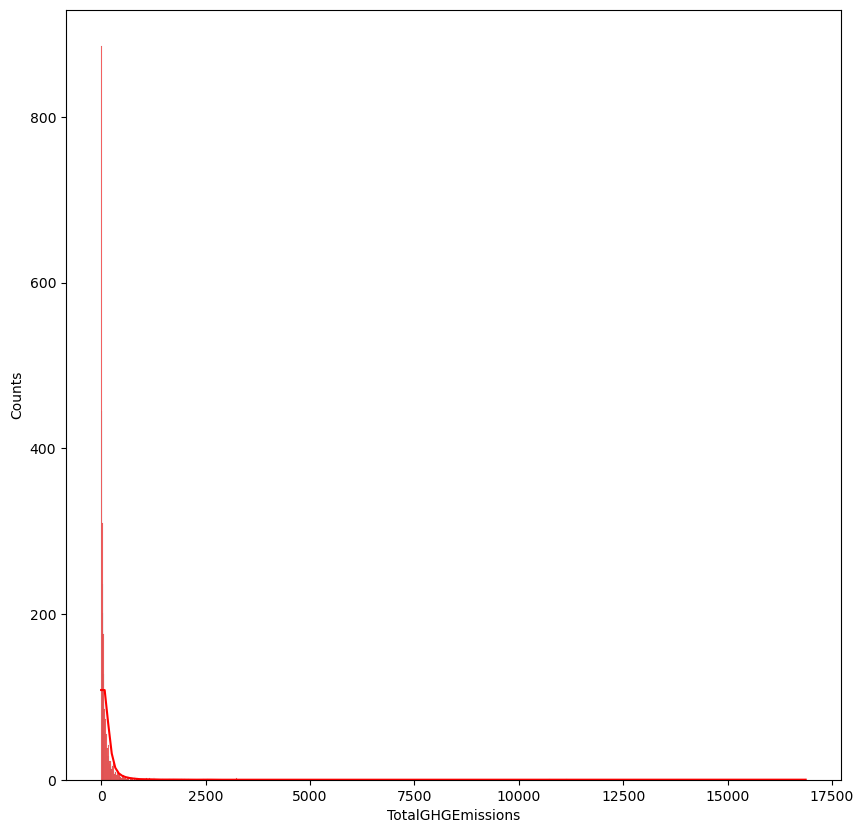

In [55]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(10, 10))


sns.histplot(data=data, x="TotalGHGEmissions", kde=True, ax=ax, color="red", alpha=0.6)
plt.xlabel('TotalGHGEmissions')
plt.ylabel('Counts')
plt.show()

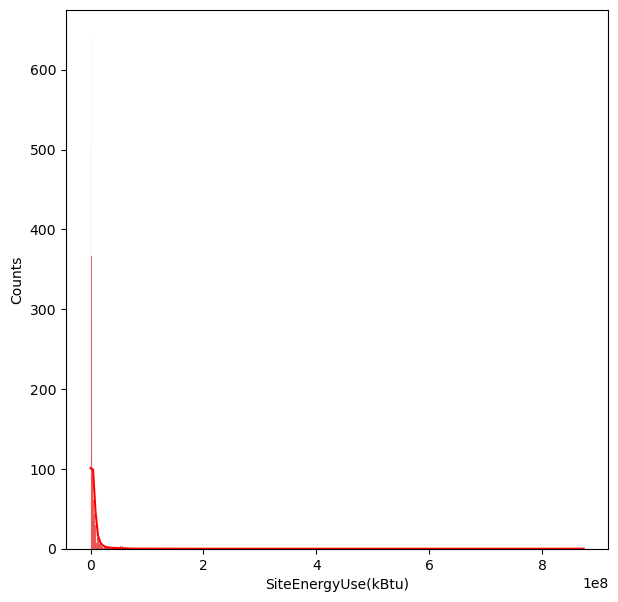

In [56]:
import scipy.stats as stats
fig, ax = plt.subplots(figsize=(7, 7))


sns.histplot(data=data, x="SiteEnergyUse(kBtu)", kde=True, ax=ax, color="red", alpha=0.6)
#plt.ylim([0,300])
plt.xlabel('SiteEnergyUse(kBtu)')
plt.ylabel('Counts')
plt.show()

Projettons à présent les scatterplots des distribition de ces 2 variables entre elles :

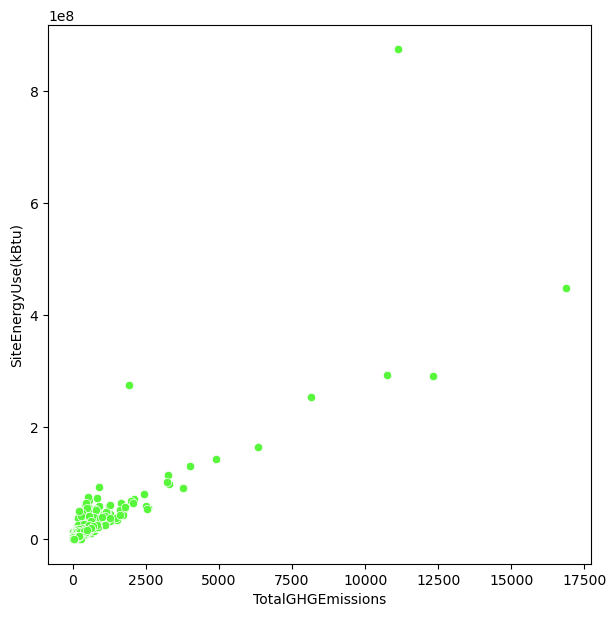

In [57]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(data=data[(data['TotalGHGEmissions'] < 1e6)], x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)")
plt.show()  #

Nous allons à présent regarder la répartition de ces 2 variables en fonction du type de bâtiement.

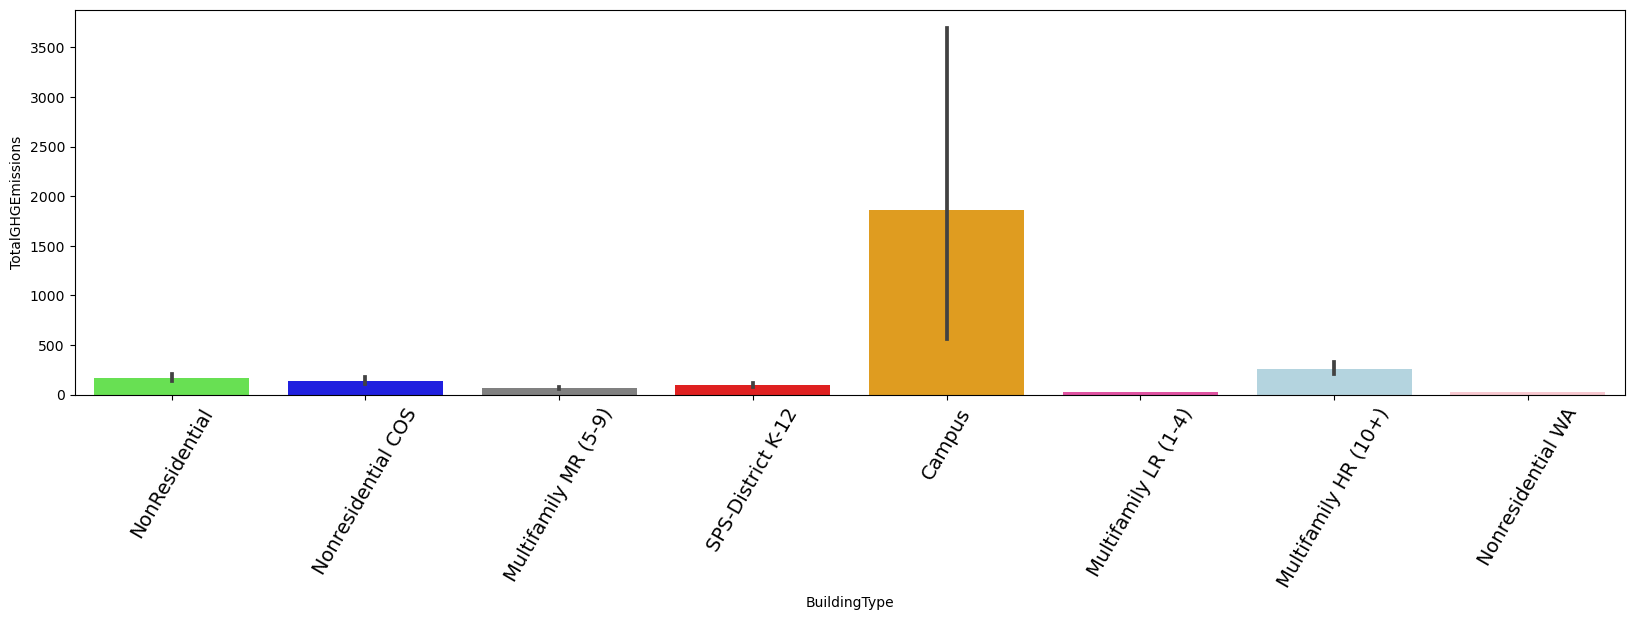

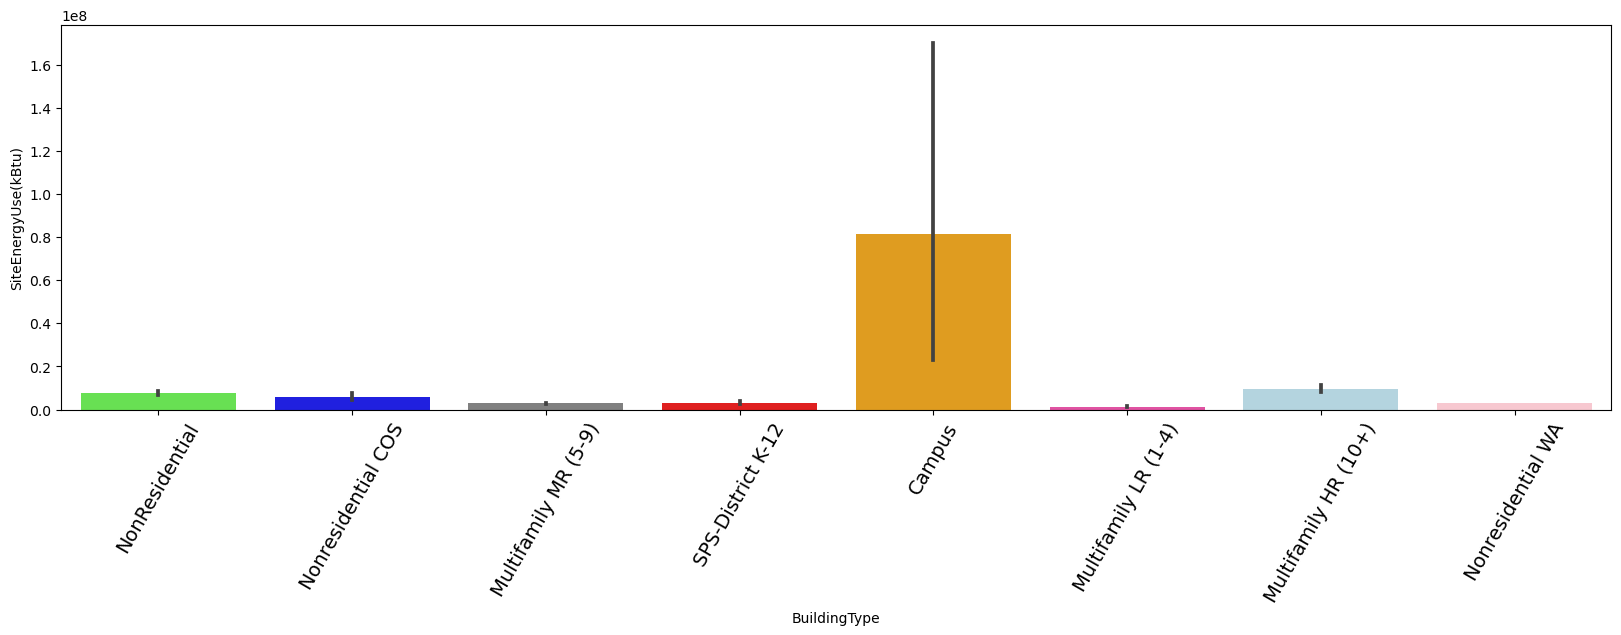

In [58]:
fig = plt.figure(figsize=(20,5))
sns.barplot(x='BuildingType',y='TotalGHGEmissions',data=data)
plt.xticks(rotation='60', fontsize=14)

fig = plt.figure(figsize=(20,5))
sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)',data=data)
plt.xticks(rotation='60', fontsize=14)


plt.show()

Nous allons à présent regarder la répartition de ces 2 variables en fonction du Number of Floor.

### 3. Selectionnons les varibales pour prochaine etape



Nous allons éliminer certaines variables qui ne seront pas utiles pour nos modélisations et vérifier les données incomplètes identifiées dans le jeu de données initial.

In [59]:
print("Nombre de ligne identifiées comme non conforme : {}.".format(data[data['ComplianceStatus'] != "Compliant"].shape[0]))

Nombre de ligne identifiées comme non conforme : 128.


In [60]:
data = data[data['ComplianceStatus'] == "Compliant"]

Nous allons ensuite supprimer les variables `DefaultData`, `ComplianceStatus`, `TaxParcelIdentificationNumber`, `CouncilDistrictCode`, `City` 

In [61]:
data = data.drop(['DefaultData','ComplianceStatus',
                  'TaxParcelIdentificationNumber','CouncilDistrictCode'], axis=1)

In [62]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'Campus', 'SPS-District K-12', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Supprimer les lignes qui contiennent la chaîne de caractère "Multifamily" 

In [63]:
data = data[~data['BuildingType'].str.contains("Multifamily")]
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Campus',
       'SPS-District K-12', 'Nonresidential WA'], dtype=object)

In [64]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily'],
      dtype=object)

In [65]:
data = data[~data['PrimaryPropertyType'].str.contains("Multifamily")]
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant'], dtype=object)

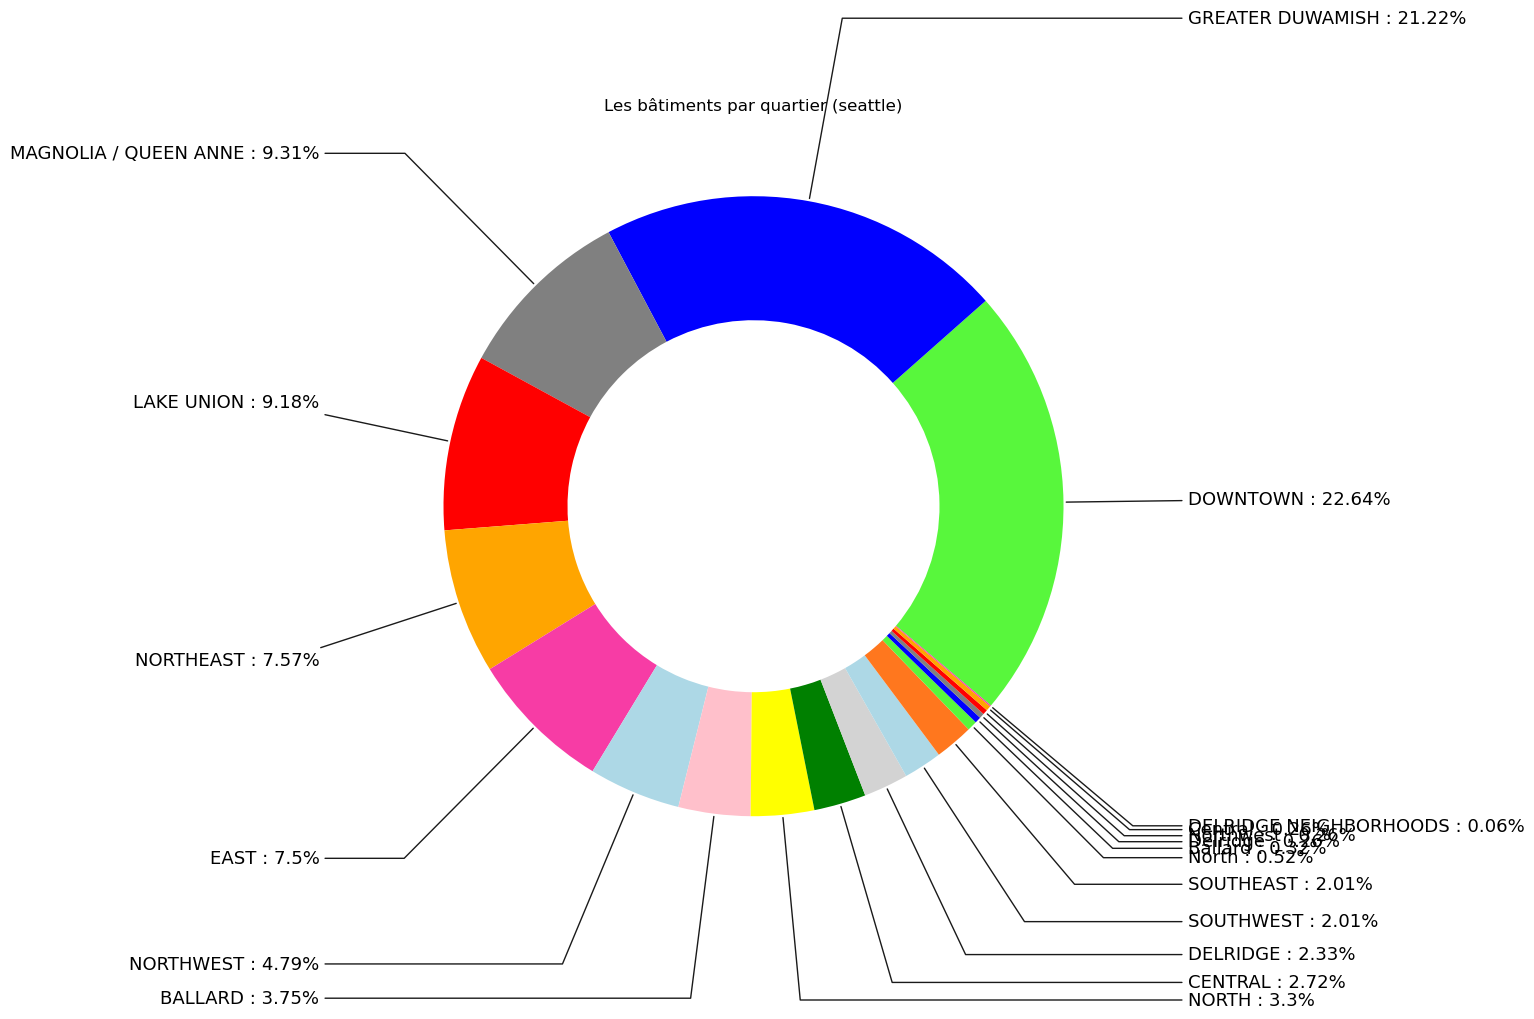

In [66]:
fig, ax = plt.subplots(figsize=(10, 15), subplot_kw=dict(aspect="equal"))

# colors = ['#58F73C', 'blue', 'gray', 'darkred', 'red', 'orange', '#F73CA5', 'white', 'darkgreen', 'lightgreen', 
#           '#FFFC1E', 'lightblue', '#FF771E', '#ffd100', 'pink', 'cadetblue', 'lightgray', '#f48100', 'yellow']
y_values = data['Neighborhood'].value_counts().index
x_values = data['Neighborhood'].value_counts().values

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow','green', 'lightgray', 'lightblue', '#FF771E']

wedges, texts = plt.pie(x_values, wedgeprops=dict(width=0.4), startangle=-40, colors=colors)

kw = dict(arrowprops=dict(arrowstyle="-"),
          zorder=0, va="center",fontsize=13)

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1) / 2 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle}, color="0.1")
    ax.annotate(y_values[i]+' : '+np.round(((x_values[i]/sum(x_values))*100),2).astype(str)+'%',
                xy=(x, y), xytext=(1.4 * np.sign(x), 1.6 * y),
                horizontalalignment=horizontalalignment, **kw)


plt.title('Les bâtiments par quartier (seattle)', fontsize=12)

# plt.legend(y_values, loc=[1.06, 0.22], labels=['%s : %1.2f%%' % (l, s) for l, s in zip(y, (x / sum(x)) * 100)],fontsize=14, facecolor='#fbf8f8')
plt.show()

L'energie totale utilisée par quartie de la ville de Seattle.

Il faut calculer la moyenne de consommation énergétique par quartier

In [67]:
quartier = data['Neighborhood'].unique()

df_quartier = pd.DataFrame(index=range(0,len(quartier)), columns = ['quartier'])
df_quartier

df_quartier['Mean_Energy_Hood'] = 0
df_quartier['Mean_CO2_Hood'] = 0

for i in range (len(quartier)):
  df_quartier['quartier'][i] = quartier[i]
  df_quartier['Mean_Energy_Hood'].values[i] = data['SiteEnergyUse(kBtu)'][data['Neighborhood'] == quartier[i]].mean()
  df_quartier['Mean_CO2_Hood'].values[i] = data['TotalGHGEmissions'][data['Neighborhood'] == quartier[i]].mean()

df_quartier

quartier  Mean_Energy_Hood  Mean_CO2_Hood
0                 DOWNTOWN          12223812            216
1                NORTHEAST          15371068            282
2                     EAST          14729221            494
3               LAKE UNION          10288065            199
4         GREATER DUWAMISH           5364897            122
5    MAGNOLIA / QUEEN ANNE           5997856            132
6                  BALLARD           4588123            120
7                NORTHWEST           6382352            160
8                  CENTRAL           6963231            184
9                SOUTHWEST           5241634            163
10               SOUTHEAST           4488561            115
11                DELRIDGE           4645242            111
12                   NORTH           4230445             89
13                   North           5413033             97
14                Delridge          10661246             62
15                 Ballard           2134425             25
16               Northwest           2155786             72
17                 Central           4579433            132
18  DELRIDGE NEIGHBORHOODS            932082             20

 Graphique de la quantité moyenne annuelle d'énergie consommée par quartier

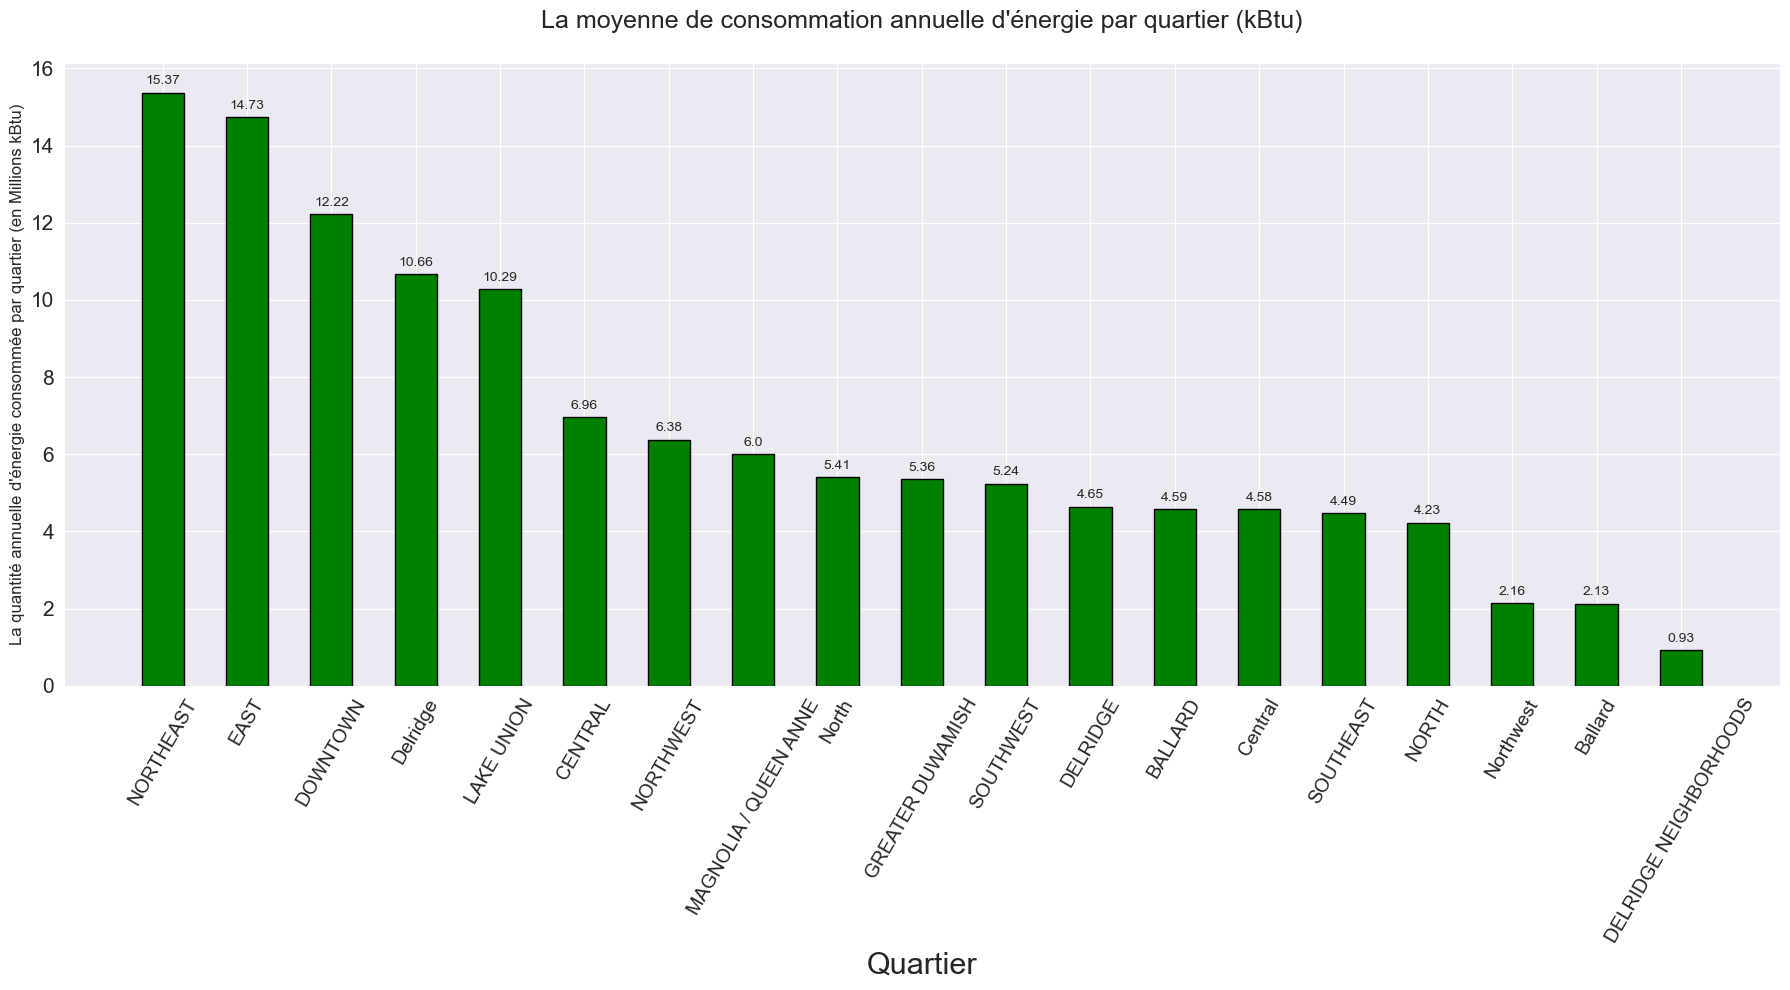

In [68]:
sns.set_style("darkgrid")

df_quartier = df_quartier.sort_values(by=['Mean_Energy_Hood'],ascending=False)


labels_i = df_quartier['quartier']

xi = np.arange(len(labels_i)) 


width = 0.50  # the width of the bars

fig, ax = plt.subplots()

graph = ax.bar(xi,df_quartier['Mean_Energy_Hood']/1000000, width, color='green',
               edgecolor="black", align='center')

# Ajouter les annotations sur les barres
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    plt.annotate(np.round(p.get_height(),decimals=2),
                (p.get_x()+p.get_width()/2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points',
                fontsize = 10,
                )

# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(18, 10)
ax.set_ylabel("La quantité annuelle d'énergie consommée par quartier (en Millions kBtu)", fontsize=12)
ax.set_title("La moyenne de consommation annuelle d'énergie par quartier (kBtu)\n", fontsize=18)
ax.set_xticks(xi)
ax.set_xticklabels(labels_i)
plt.xticks(rotation='60', fontsize=14)
plt.yticks(fontsize=15)
plt.xlabel('Quartier', fontsize=22)

fig.tight_layout()

### La quantité annuelle d'énergie consommée Par quartier

Text(0.5, 0, 'Quartier')

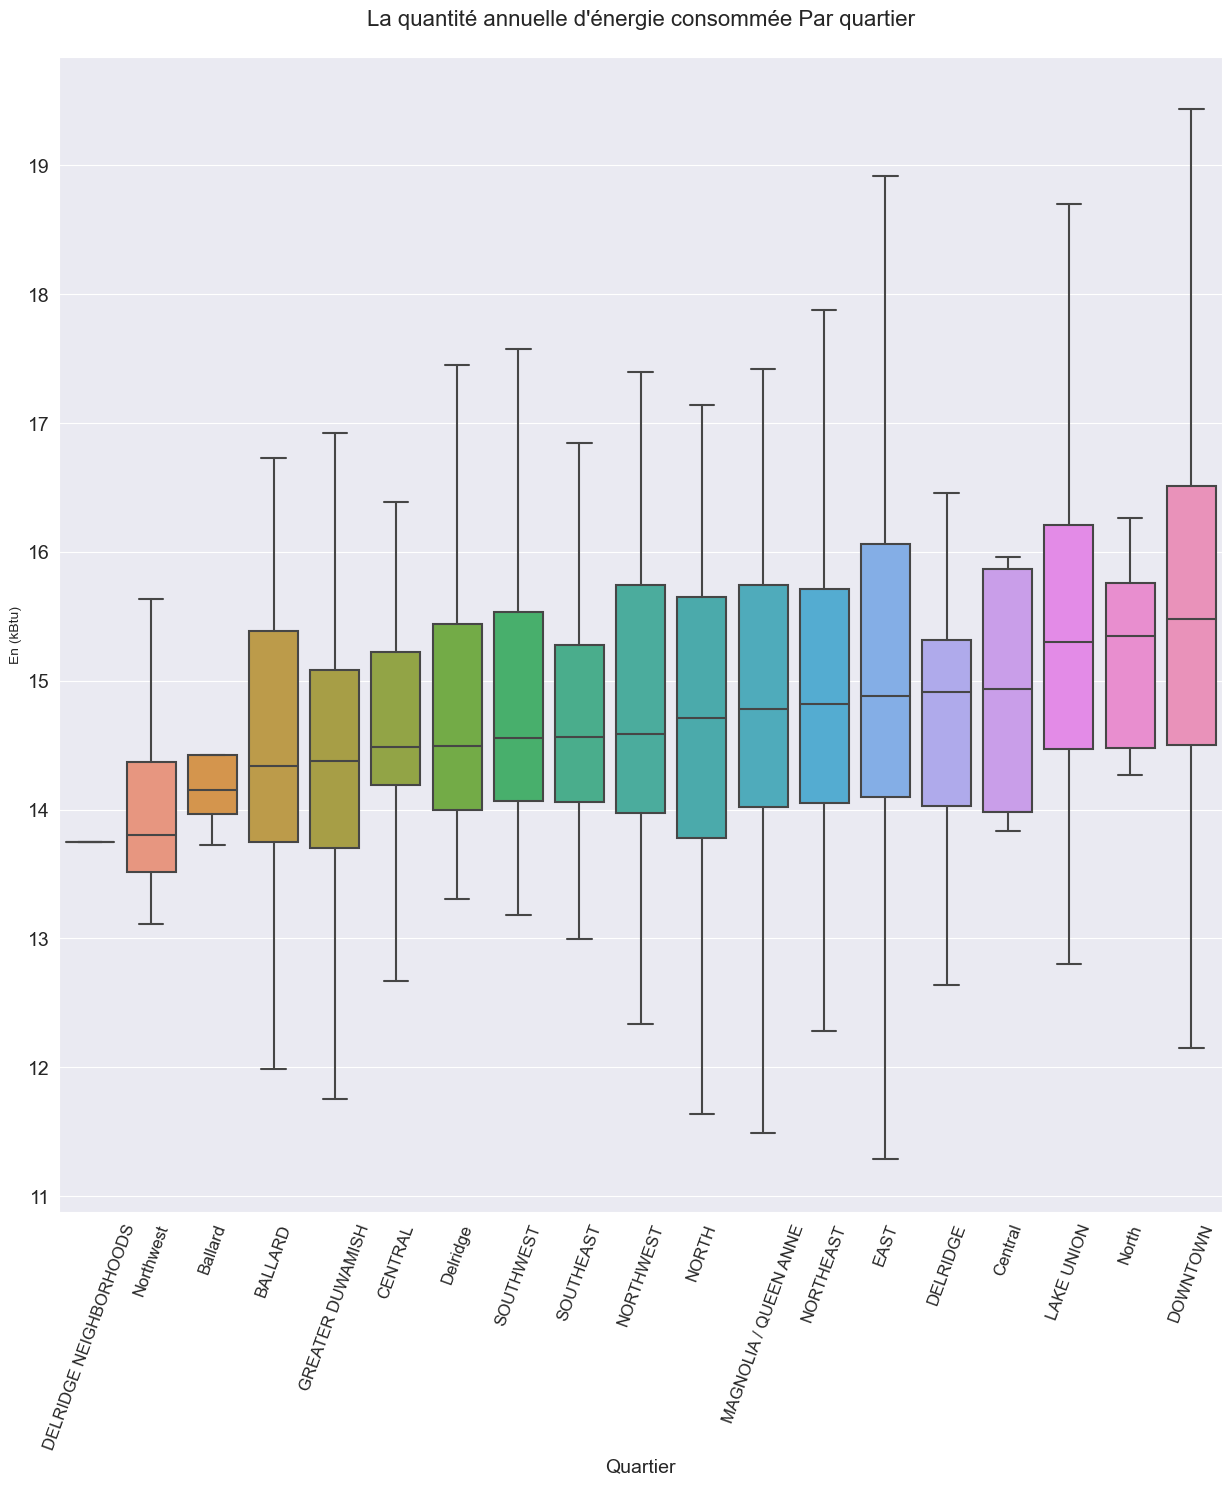

In [69]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


var_y = data['SiteEnergyUse(kBtu)']

grouped = data.loc[:,['Neighborhood', 'SiteEnergyUse(kBtu)']] \
    .groupby(['Neighborhood']) \
    .median() \
    .sort_values(by='SiteEnergyUse(kBtu)')



sns.boxplot(x= data['Neighborhood'], y = np.log(data['SiteEnergyUse(kBtu)']), 
            data = data, order=grouped.index,showfliers=False)
# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(15, 15)
ax.set_ylabel("En (kBtu)", fontsize=10)
ax.set_title("La quantité annuelle d'énergie consommée Par quartier\n", fontsize=16)

plt.xticks(rotation='70', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Quartier', fontsize=14)

### La quantité totale d'émissions de CO2  par Quartier

Text(0.5, 0, 'Quartier')

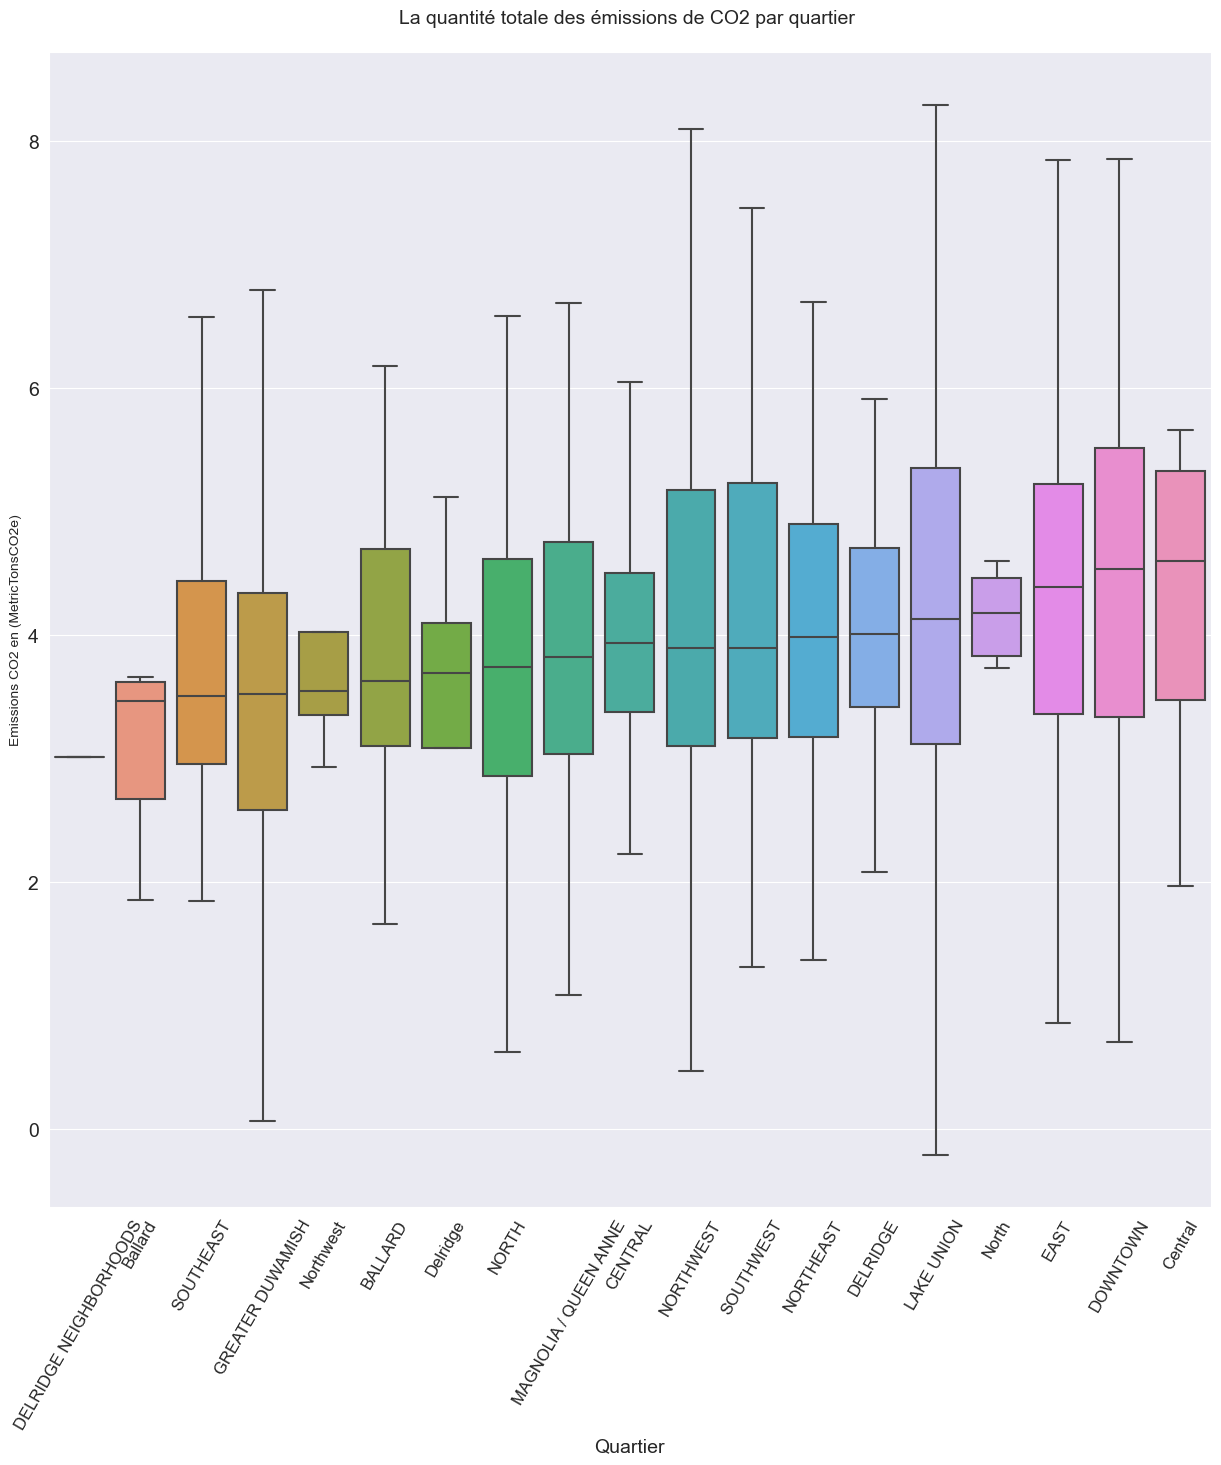

In [70]:
fig, ax = plt.subplots()

colors = ['#58F73C', 'blue', 'gray', 'red', 'orange', '#F73CA5', 'lightblue', 'pink', 'yellow']


sns.set_palette(sns.color_palette(colors))


var_y = data['TotalGHGEmissions']

grouped = data.loc[:,['Neighborhood', 'TotalGHGEmissions']] \
    .groupby(['Neighborhood']) \
    .median() \
    .sort_values(by='TotalGHGEmissions')



sns.boxplot(x= data['Neighborhood'], y = np.log(data['TotalGHGEmissions']), data = data, 
            order=grouped.index,showfliers=False)
# Ajouter des textes aux labels, titre etc.
fig.set_size_inches(15, 15)
ax.set_ylabel('Emissions CO2 en (MetricTonsCO2e)', fontsize=10)
ax.set_title("La quantité totale des émissions de CO2 par quartier \n", fontsize=14)

plt.xticks(rotation='60', fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Quartier', fontsize=14)

In [71]:
data['energy_grad'] = ''
def energy_grad(df):

  df.loc[df.eval("ENERGYSTARScore <= 20"), "energy_grad"]="D"
  df.loc[df.eval("ENERGYSTARScore > 20"), "energy_grad"]="C"
  df.loc[df.eval("ENERGYSTARScore > 60"), "energy_grad"]="B"
  df.loc[df.eval("ENERGYSTARScore > 60"), "energy_grad"]="A"
  df.loc[df.eval("ENERGYSTARScore > 80"), "energy_grad"]="A+"
  df.loc[df.eval("ENERGYSTARScore").isna(), "energy_grad"]="NC"

energy_grad(data)

In [72]:
data['energy_grad'].value_counts(normalize=True)*100

NC    35.575679
A+    23.350582
C     17.076326
A     16.041397
D      7.956016
Name: energy_grad, dtype: float64

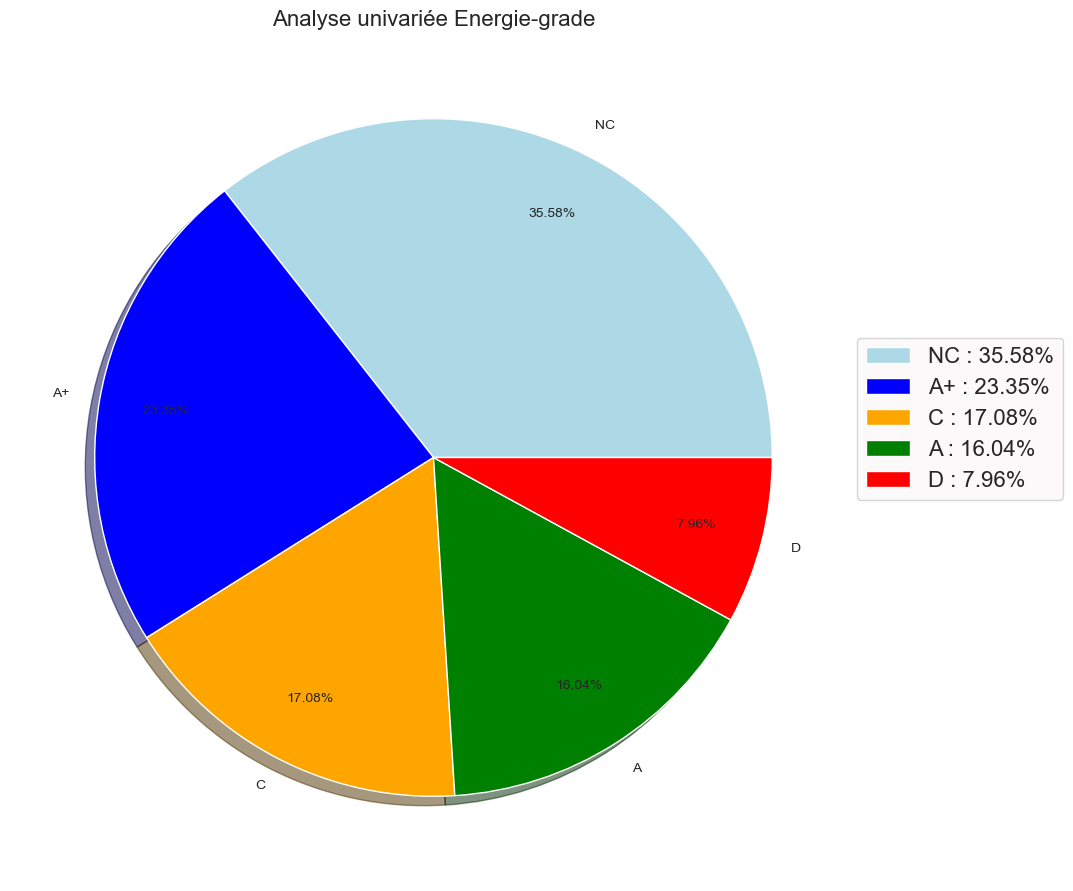

In [73]:
plt.figure(figsize=(11, 11))

y = data['energy_grad'].value_counts().index
x = data['energy_grad'].value_counts().values

colors = {'A+': 'blue', 'A': 'green', 'B': 'yellow', 'C': 'orange', 'D': 'red', 'NC': 'lightblue'}
colors = pd.DataFrame(colors, index=[len(y)])

var = colors[y.values]
var = var.values.tolist()
var = var[0]

plt.pie(x, labels=y,
colors=var,
#explode=[0.2, 0, 0, 0, 0],
autopct=lambda x: str(round(x, 2)) + '%',
pctdistance=0.8, labeldistance=1.09,
shadow=True)

plt.title('Analyse univariée Energie-grade', fontsize=16)

plt.legend(y, loc=[1, 0.45], labels=['%s : %1.2f%%' % (l, s) for l, s in zip(y, (x / sum(x)) * 100)],fontsize=16, facecolor='#fbf8f8')

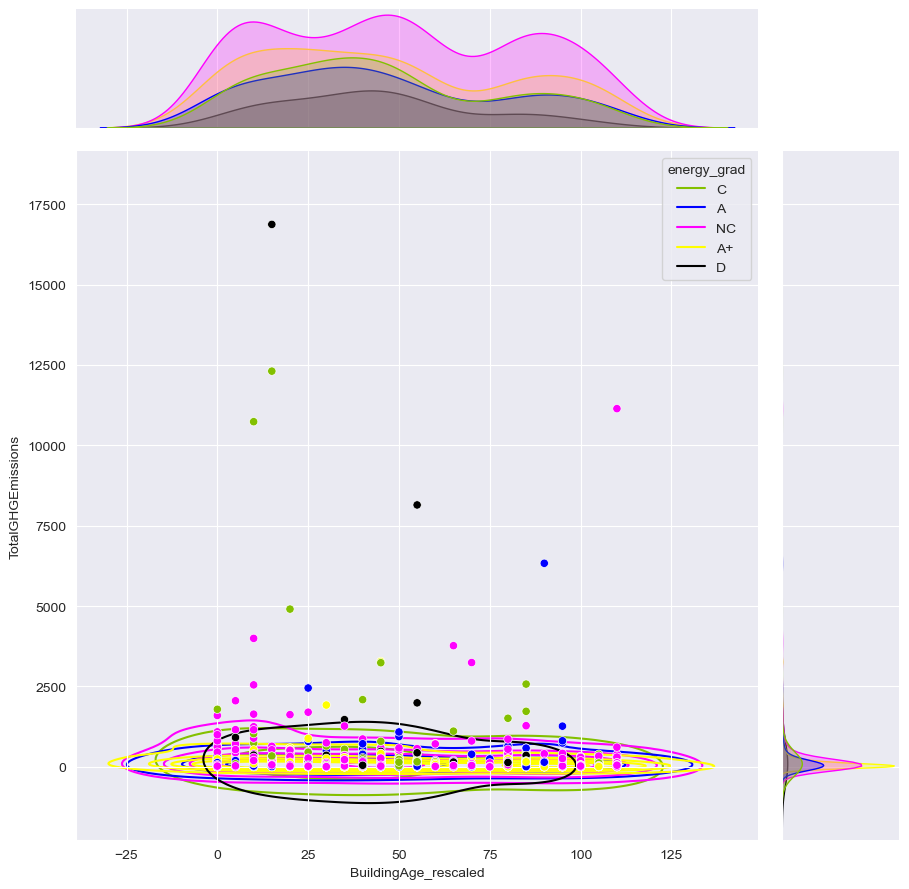

In [74]:
colors = ['#83c000','blue','magenta', 'yellow', 'black', 'orange','red','#008236']

sns.set_palette(sns.color_palette(colors))
g = (sns.jointplot(x="BuildingAge_rescaled", y="TotalGHGEmissions", data=data, hue='energy_grad', height=9).plot_joint(sns.kdeplot, zorder=0, n_levels=6))

### Reverfions la correlation

In [75]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

level_0                level_1  corr_coeff
22      Electricity(kBtu)    SiteEnergyUse(kBtu)    0.956670
20       SiteEUI(kBtu/sf)     SourceEUI(kBtu/sf)    0.943898
18    Energy_use_par_area       SiteEUI(kBtu/sf)    0.925029
16    SiteEnergyUse(kBtu)      TotalGHGEmissions    0.863001
14       PropertyGFATotal      Electricity(kBtu)    0.850378
12    Energy_use_par_area  GHGEmissionsIntensity    0.848735
10    Energy_use_par_area     SourceEUI(kBtu/sf)    0.844918
8        PropertyGFATotal    SiteEnergyUse(kBtu)    0.797056
6       Electricity(kBtu)      NumberofBuildings    0.736567
4        SiteEUI(kBtu/sf)  GHGEmissionsIntensity    0.735452
2        NaturalGas(kBtu)      TotalGHGEmissions    0.732376
0   GFABuildingNormalised   GFAParkingNormalised   -1.000000

### Ici on peut effacer les autres collonnes qui ne sont utile dans notre analyse

In [76]:
to_drop=['OSEBuildingID','DataYear','LargestPropertyUseType','PropertyName', 'Address','Latitude','Longitude',
         'YearsENERGYSTARCertified','ThirdLargestPropertyUseType', 
         'Energy_Source_proportion','energy_grad','Energy_use_par_area','LargestPropertyUseType','ZipCode','ListOfAllPropertyUseTypes']

In [77]:
data=data.drop(to_drop,axis=1)

In [78]:
data.isnull().sum()

BuildingType               0
PrimaryPropertyType        0
City                       0
State                      0
Neighborhood               0
NumberofBuildings          0
NumberofFloors             0
PropertyGFATotal           0
ENERGYSTARScore          550
SiteEnergyUse(kBtu)        0
TotalGHGEmissions          0
BuildingAge_rescaled       0
GFABuildingNormalised      0
GFAParkingNormalised       0
GFAPerBuilding            52
GFAPerFloor               16
Electricity_ratio          0
Natural_gas_ratio          0
SteamUse_ratio             0
dtype: int64

### On voit qu'il y a toujours les valeurs manquantes, on va les remplacer par la medianne

In [79]:
med = data['GFAPerBuilding'].median()
data['GFAPerBuilding'].fillna(med, inplace=True)
me = data['GFAPerFloor'].median()
data['GFAPerFloor'].fillna(me, inplace=True)

In [80]:
data.isnull().sum()

BuildingType               0
PrimaryPropertyType        0
City                       0
State                      0
Neighborhood               0
NumberofBuildings          0
NumberofFloors             0
PropertyGFATotal           0
ENERGYSTARScore          550
SiteEnergyUse(kBtu)        0
TotalGHGEmissions          0
BuildingAge_rescaled       0
GFABuildingNormalised      0
GFAParkingNormalised       0
GFAPerBuilding             0
GFAPerFloor                0
Electricity_ratio          0
Natural_gas_ratio          0
SteamUse_ratio             0
dtype: int64

**Ici on va elimite les collones qui ont une seule valeur unique pour eviter que elles peuvent fausser les predictions**

In [81]:
data['State'].unique()

array(['WA'], dtype=object)

In [82]:
data['City'].unique()

array(['Seattle'], dtype=object)

***On voit que City et State sont constants , il vaut mieux les suprimer***

In [83]:
data= data.drop(['State','City'], axis=1)

les Campus sont très consommateurs en energie. Nous allons vérifier la distribution des consommations en fonction des surfaces totales au sol par catégorie de bâtiment. D'éventuels valeurs hors-normes pourraient poser des problèmes pour les modélisations :

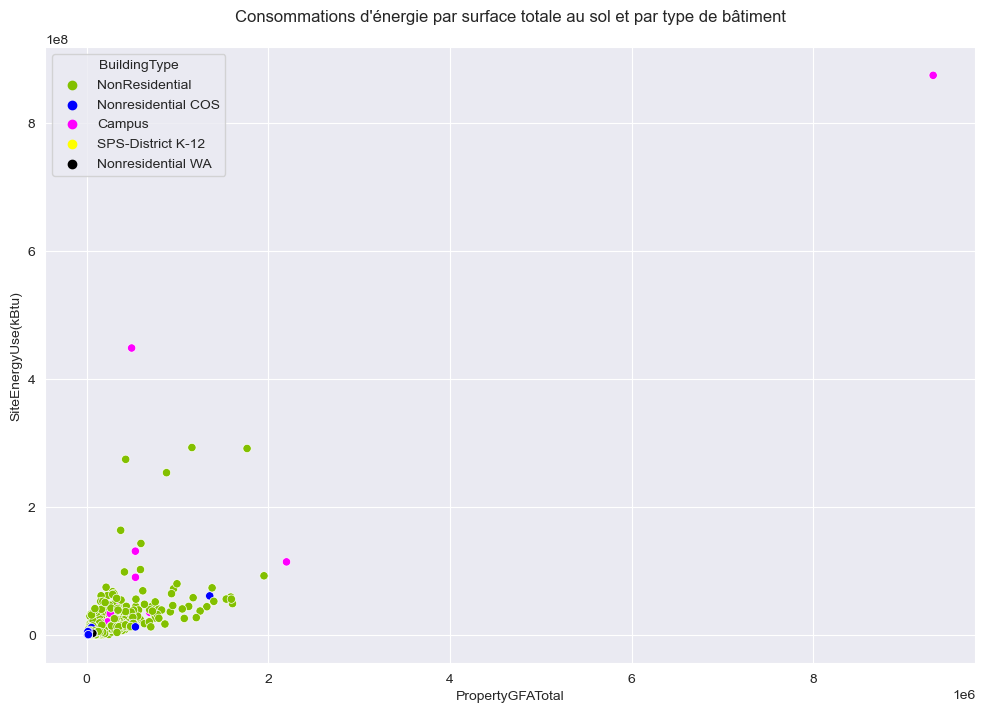

In [84]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='SiteEnergyUse(kBtu)', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n")
         
plt.show()

Un bâtiment de type campus est très supérieur aux autres données. Il ne s'agit sans doute pas d'une valeur abérrante mais d'une **valeur atypique** qui est très isolée. Nous allons ici la supprimer de nos données sources.

In [272]:
data[data['SiteEnergyUse(kBtu)']>8*10**8]

BuildingType PrimaryPropertyType Neighborhood  NumberofBuildings  \
3243       Campus          University    NORTHEAST              111.0   

      NumberofFloors  PropertyGFATotal  ENERGYSTARScore  SiteEnergyUse(kBtu)  \
3243             0.0         9320156.0              NaN          873923712.0   

      TotalGHGEmissions  BuildingAge_rescaled  GFABuildingNormalised  \
3243           11140.56                   110                    1.0   

      GFAParkingNormalised  GFAPerBuilding  GFAPerFloor  Electricity_ratio  \
3243                   0.0       83965.369   22178.9285            0.75187   

      Natural_gas_ratio  SteamUse_ratio  
3243                0.0         0.09725

In [273]:
med=data['SiteEnergyUse(kBtu)'].median()

In [274]:
#replace any values in 'points' column greater than 10 with 20
data.loc[data['SiteEnergyUse(kBtu)'] > 8*10**8, 'SiteEnergyUse(kBtu)'] = med


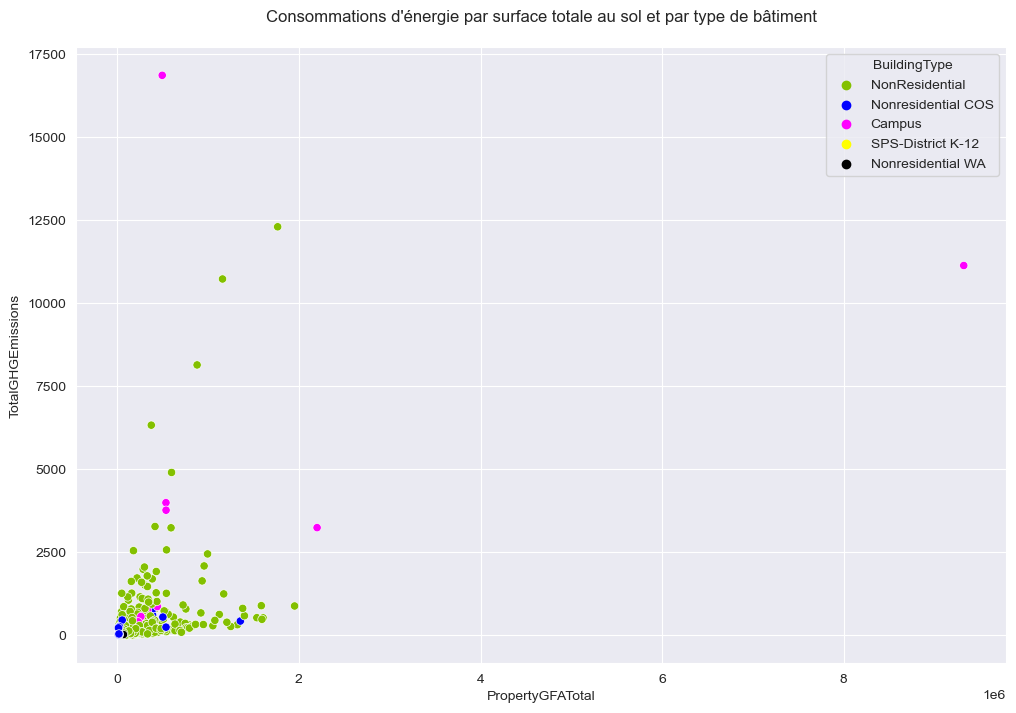

In [275]:
font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig = plt.figure(figsize=(12,8))
sns.scatterplot(data = data, x='PropertyGFATotal', y='TotalGHGEmissions', hue='BuildingType')
plt.title(f"Consommations d'énergie par surface totale au sol et par type de bâtiment\n")
         
plt.show()

In [276]:
med=data['TotalGHGEmissions'].median()

In [277]:
#replace any values in 'points' column greater than 10 with 20
data.loc[data['TotalGHGEmissions'] > 12500, 'TotalGHGEmissions'] = med


In [278]:
med=data['PropertyGFATotal'].median()

In [279]:
data.loc[data['PropertyGFATotal'] > 9000000,'PropertyGFATotal'] = med

### Ecrire le collonne pertinente dans le fichier .

In [280]:
data.to_csv("data_cleaned.csv",index=False)